In [1]:
%load_ext autoreload
%matplotlib widget
%autoreload 2
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from datetime import datetime

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_color_value,
    reconstruct_image_from_general,
    plot_full,
    find_nearest_edge,
)
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    get_width_info,
    get_width_info_new,
)
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
)
import pandas as pd
from amftrack.pipeline.functions.spore_processing.spore_id import make_spore_data
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import (
    resolve_anastomosis_crossing_by_root,
)
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
    Edge,
    Hyphae,
)
from datetime import datetime
from matplotlib import cm
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from IPython.display import clear_output
from amftrack.pipeline.functions.post_processing.exp_plot import *

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-08-08 17:58:44.198301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 17:58:44.795914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home2/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/cv2/../../lib64:
2023-08-08 17:58:44.795971: I tensorflow/stream_executor/cuda/cudart_stub.cc:29

In [2]:
plates = [
    "94_20201123",
]
directory_targ = directory_project
update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/1912 [00:00<?, ?it/s]

In [3]:
folders = all_folders.loc[all_folders["unique_id"] == "94_20201123"]
folders = folders.sort_values(by="datetime")
folders = folders.iloc[72:73]

exp = Experiment(directory_targ)
exp.load(folders)
exp.dates.sort()
for t in range(len(folders)):
    exp.load_tile_information(t)

2020-11-26 13:02:00


In [4]:
load_graphs(exp, directory_targ)
exp.save_location = ""

load_study_zone(exp)

In [5]:
import networkx as nx
G = exp.nx_graph[t]
components = nx.connected_components(G)

# Find the largest connected component
largest_component = max(components, key=len)

# Create a new graph representing the largest connected component
largest_component_graph = G.subgraph(largest_component)
exp.nx_graph[t] = largest_component_graph

In [6]:
t = len(folders) - 1
exp.load_tile_information(t)
spore_datatable = make_spore_data(exp)
spore_datatable = spore_datatable.loc[spore_datatable["t"] == t]
node_x = np.array([node.pos(t)[0] for node in get_all_nodes(exp,t)])
node_y = np.array([node.pos(t)[1] for node in get_all_nodes(exp,t)])
distances = []

# For each row in the datatable
for index, row in spore_datatable.iterrows():
    x = row['x']
    y = row['y']

    # Compute the distances to all the points in the cloud
    dists = np.sqrt((x - node_x)**2 + (y - node_y)**2)

    # Here we take the minimum distance to the cloud of points, but you can modify this as required.
    min_dist = np.min(dists)

    distances.append(min_dist)

spore_datatable['distance_to_cloud'] = distances

select = spore_datatable.loc[spore_datatable['distance_to_cloud']<=100]

In [7]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

In [11]:
edges = get_all_edges(exp, t)
bas = [edge for edge in edges if g(edge)]

In [12]:
def get_betweenness_max_min(exp, t):
    edges = get_all_edges(exp, t)
    betweenness = [edge.betweeness(t) for edge in edges if edge.betweeness(t) > 0]
    return (np.min(betweenness), np.max(betweenness))
mini,maxi = get_betweenness_max_min(exp, t)

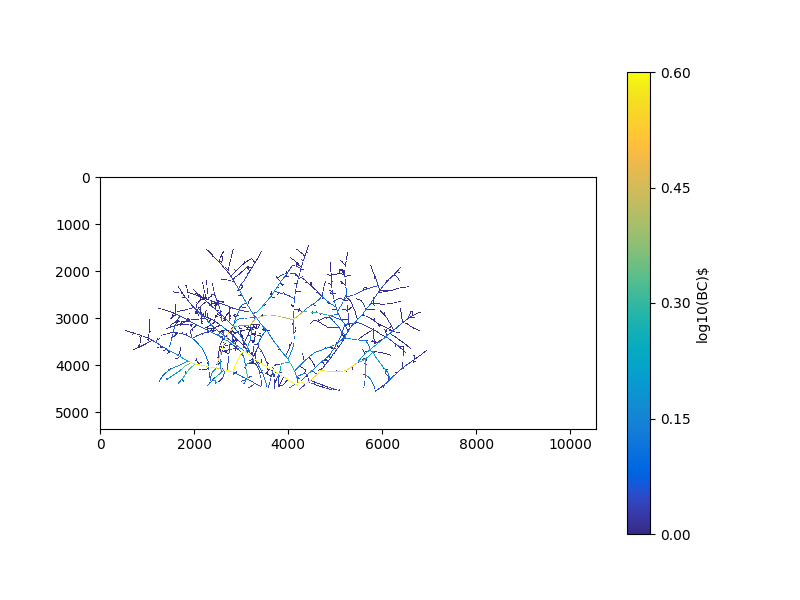

In [29]:
plt.close("all")
vmax = 0
vmin = -3
vmax = 0.6
vmin = 0
downsizing = 5
fig,ax = plot_edge_color_value_no_bas(
    exp,
    t,
    lambda edge: edge.betweeness(t)/maxi,
    cmap=parula_map,
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=15,
    figsize = (8,6),
    downsizing = downsizing,
    alpha = 1,
    label_colorbar='log10(BC)$',
    
)
for index, row in select.iterrows():
    ax.scatter(
        row["y"] / downsizing, row["x"] / downsizing, s=row['radius'], color="brown", alpha=1
    )
plot_bas(
    exp,
    t,
    ax,
    edges = bas,
dilation=10)

In [27]:
dpi = 600
path = r"figures"
file_name = f"full.pdf"
save_path = os.path.join(path, file_name)
plt.savefig(save_path, bbox_inches='tight',transparent=True)


In [8]:
def g(edge):
    boolean = (edge.end.degree(t) == 1 or edge.begin.degree(t) == 1) and edge.length_um(
        t
    ) < 1000
    # boolean +=((edge.width(t)*edge.length_um(t))<3000)*edge.width(t)<7
    return boolean

In [20]:
from amftrack.pipeline.functions.image_processing.experiment_util import *
def plot_bas(
    exp: Experiment,
    t: int,
    ax,
    region=None,
    edges: List[Edge] = [],
    points: List[coord_int] = [],
    segments: List[List[coord_int]] = [],
    nodes: List[Node] = [],
    downsizing=5,
    dilation=1,
    save_path="",
    prettify=False,
    with_point_label=False,
    figsize=(12, 8),
    dpi=None,
    node_size=5,
) -> None:
    """
    This is the general purpose function to plot the full image or a region `region` of the image at
    any given timestep t. The region being specified in the GENERAL coordinates.
    The image can be downsized by a chosen factor `downsized` with additionnal features such as: edges, nodes, points, segments.
    The coordinates for all the objects are provided in the GENERAL referential.

    :param region: choosen region in the full image, such as [[100, 100], [2000,2000]], if None the full image is shown
    :param edges: list of edges to plot, it is the pixel list that is plotted, not a straight line
    :param nodes: list of nodes to plot (only nodes in the `region` will be shown)
    :param points: points such as [123, 234] to plot with a red cross on the image
    :param segments: plot lines between two points that are provided
    :param downsizing: factor by which we reduce the image resolution (5 -> image 25 times lighter)
    :param dilation: only for edges: thickness of the edges (dilation applied to the pixel list)
    :param save_path: full path to the location where the plot will be saved
    :param prettify: if True, the image will be enhanced by smoothing the intersections between images
    :param with_point_label: if True, the index of the point is ploted on top of it

    NB: the full region of a full image is typically [[0, 0], [26000, 52000]]
    NB: the interesting region of a full image is typically [[12000, 15000], [26000, 35000]]
    NB: the colors are chosen randomly for edges
    NB: giving a smaller region greatly increase computation time
    """

    # TODO(FK): fetch image size from experiment object here, and use it in reconstruct image
    # TODO(FK): colors for edges are not consistent
    # NB: possible other parameters that could be added: alpha between layers, colors for object, figure_size
    DIM_X, DIM_Y = get_dimX_dimY(exp)

    if region == None:
        # Full image
        image_coodinates = exp.image_coordinates[t]
        region = get_bounding_box(image_coodinates)
        region[1][0] += DIM_X  # TODO(FK): Shouldn't be hardcoded
        region[1][1] += DIM_Y

    # 1/ Image layer
    im, f = reconstruct_image_from_general(
        exp,
        t,
        downsizing=downsizing,
        region=region,
        prettify=prettify,
        white_background=False,  # TODO(FK): add image dimention here dimx = ..
    )
    f_int = lambda c: f(c).astype(int)
    new_region = [
        f_int(region[0]),
        f_int(region[1]),
    ]  # should be [[0, 0], [d_x/downsized, d_y/downsized]]

    # 2/ Edges layer
    skel_im, _ = reconstruct_skeletton(
        [edge.pixel_list(t) for edge in edges],
        region=region,
        color_list=[(255, 0, 255,255) for edge in edges],
        downsizing=downsizing,
        dilation=dilation,
    )


    ax.imshow(skel_im, alpha=1, interpolation="none")
def plot_edge_color_value_no_bas(
    exp: Experiment,
    t: int,
    color_fun: Callable,
    region=None,
    intervals=[[1, 4], [4, 6], [6, 10], [10, 20]],
    cmap=cm.get_cmap("Reds", 100),
    plot_cmap=False,
    v_max=10,
    v_min=0,
    nodes: List[Node] = [],
    downsizing=5,
    dilation=5,
    save_path="",
    color_seed=12,
    dpi=None,
    show_background=True,
    label_colorbar="Width ($\mu m)$",
    figsize=(36, 24),
    figax=None,
    alpha=0.5,
) -> None:
    """
    Plot the width for all the edges at a given timestep.

    :param region: choosen region in the full image, such as [[100, 100], [2000,2000]], if None the full image is shown
    :param color_fun: edge -> float a function of edges that needs to be color plotted

    :param nodes: list of nodes to plot
    :param downsizing: factor by which we reduce the image resolution (5 -> image 25 times lighter)
    :param dilation: only for edges: thickness of the edges (dilation applied to the pixel list)
    :param save_path: full path to the location where the plot will be saved
    :param intervals: different width intervals that will be given different colors
    :param cmap: a colormap to map width to color
    :param plot_cmap: a boolean, whether or not to plot with cmap
    :param v_max: the max width for the colorbar/colormap
    """
    DIM_X, DIM_Y = get_dimX_dimY(exp)

    if region == None:
        # Full image
        image_coodinates = exp.image_coordinates[t]
        region = get_bounding_box(image_coodinates)
        region[1][0] += DIM_X
        region[1][1] += DIM_Y

    edges = get_all_edges(exp, t)
    edges = [edge for edge in edges if not g(edge)]
    if figax is None:
        fig = plt.figure(
            figsize=figsize
        )  # width: 30 cm height: 20 cm # TODO(FK): change dpi
        ax = fig.add_subplot(111)
    else:
        fig, ax = figax

    # Give colors to edges
    default_color = 1000
    colors = []
    widths = []
    for edge in edges:
        width = color_fun(edge)
        widths.append(width)
        if not plot_cmap:
            color = default_color
            for i, interval in enumerate(intervals):
                if interval[0] <= width and width < interval[1]:
                    color = i + color_seed
            colors.append(color)
    if plot_cmap:
        colors = [cmap((width - v_min) / (v_max - v_min)) for width in widths]
    # 0/ Make color legend
    def convert(c):
        c_ = c / 255
        return (c_[0], c_[1], c_[2])

    if not plot_cmap:
        handles = []
        for i, interval in enumerate(intervals):
            handles.append(
                mpatches.Patch(
                    color=convert(make_random_color(i + color_seed)),
                    label=str(interval),
                )
            )
        handles.append(
            mpatches.Patch(color=convert(make_random_color(1000)), label="out of bound")
        )
        # fig.legend(handles=handles)
    else:
        norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        N = 5
        plt.colorbar(sm, ticks=np.linspace(v_min, v_max, N), label=label_colorbar)
    # 1/ Image layer
    if show_background:
        im, f = reconstruct_image_from_general(
            exp,
            t,
            downsizing=downsizing,
            region=region,
            prettify=False,
            white_background=False,
        )
        f_int = lambda c: f(c).astype(int)

    # 2/ Edges layer
    color_list = (
        [(np.array(color) * 255).astype(int) for color in colors] if plot_cmap else None
    )
    from_edges = reconstruct_skeletton_from_edges(
        exp,
        t,
        edges=edges,
        region=region,
        color_seeds=colors,
        color_list=color_list,
        downsizing=downsizing,
        dilation=dilation,
        timestep=False,
    )
    skel_im, _ = from_edges
    if show_background:
        new_region = [
            f_int(region[0]),
            f_int(region[1]),
        ]  # should be [[0, 0], [d_x/downsized, d_y/downsized]]

    # 3/ Fusing layers
    if show_background:
        ax.imshow(im, cmap="gray", interpolation="none")
    ax.imshow(skel_im, alpha=alpha, interpolation="none")

    # 3/ Plotting the Nodes
    size = 5
    bbox_props = dict(boxstyle="circle", fc="white")
    for node in nodes:
        c = node.pos(t)
        if is_in_bounding_box(c, region):
            c = f(node.pos(t))
            node_text = ax.text(
                c[1],
                c[0],
                str(node.label),
                ha="center",
                va="center",
                size=size,
                bbox=bbox_props,
            )

    if save_path:
        plt.savefig(save_path, dpi=dpi)
    else:
        plt.show()
    return fig,ax

In [37]:
edges = get_all_edges(exp, t)
nodes = get_all_nodes(exp, t)
nodes_source = [
    node
    for node in nodes
    if not is_in_study_zone(node, t, 1000, 150)[1]
    and is_in_study_zone(node, t, 1000, 150)[0]
]
nodes_sink = [
    node
    for node in nodes
    if is_in_study_zone(node, t, 1000, 150)[1] and node.degree(t) == 1
]

In [10]:
nodes_source_label = [562057,562065,511904,512822,512830,529474,228,229,564159,230,562095,527119]
nodes_source2 = [Node(label,exp) for label in nodes_source_label]

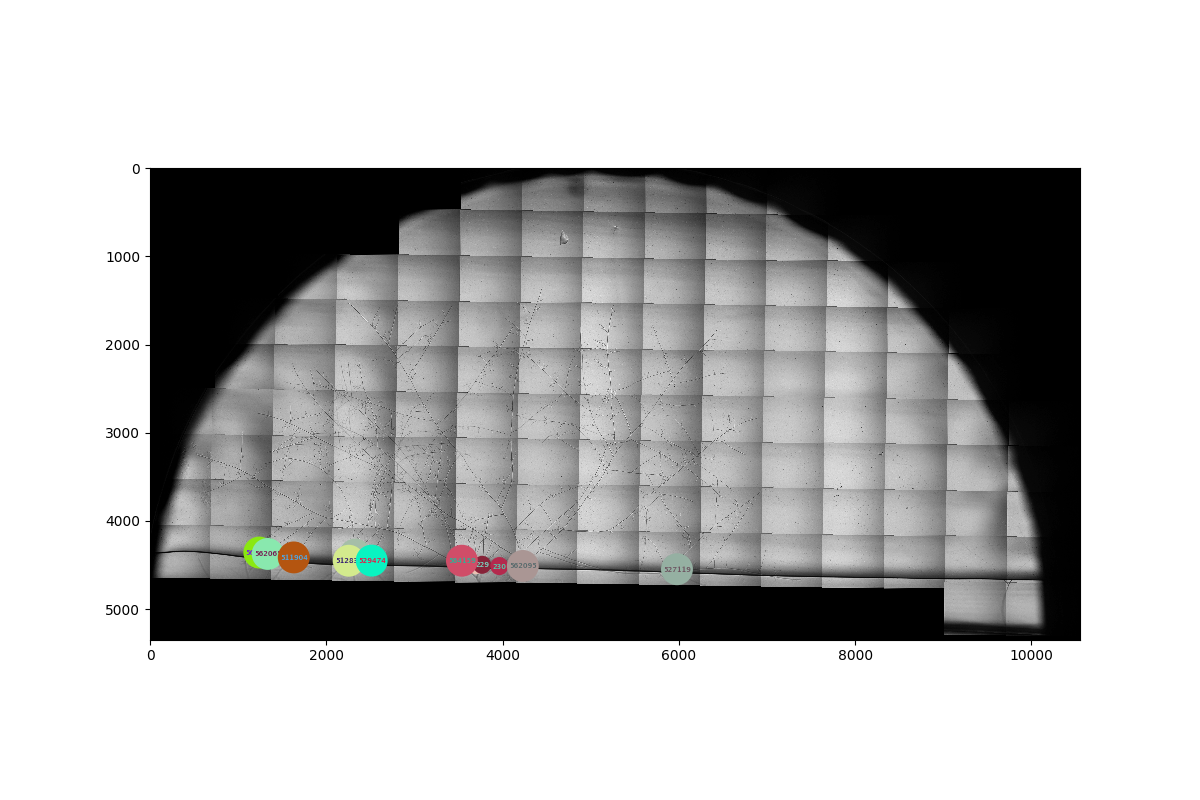

In [41]:
ax = plot_full(exp, t,nodes = nodes_source2)
# ax.scatter(
#     spore_datatable["y"] / 5, spore_datatable["x"] / 5, s=20, color="blue", alpha=0.4
# )

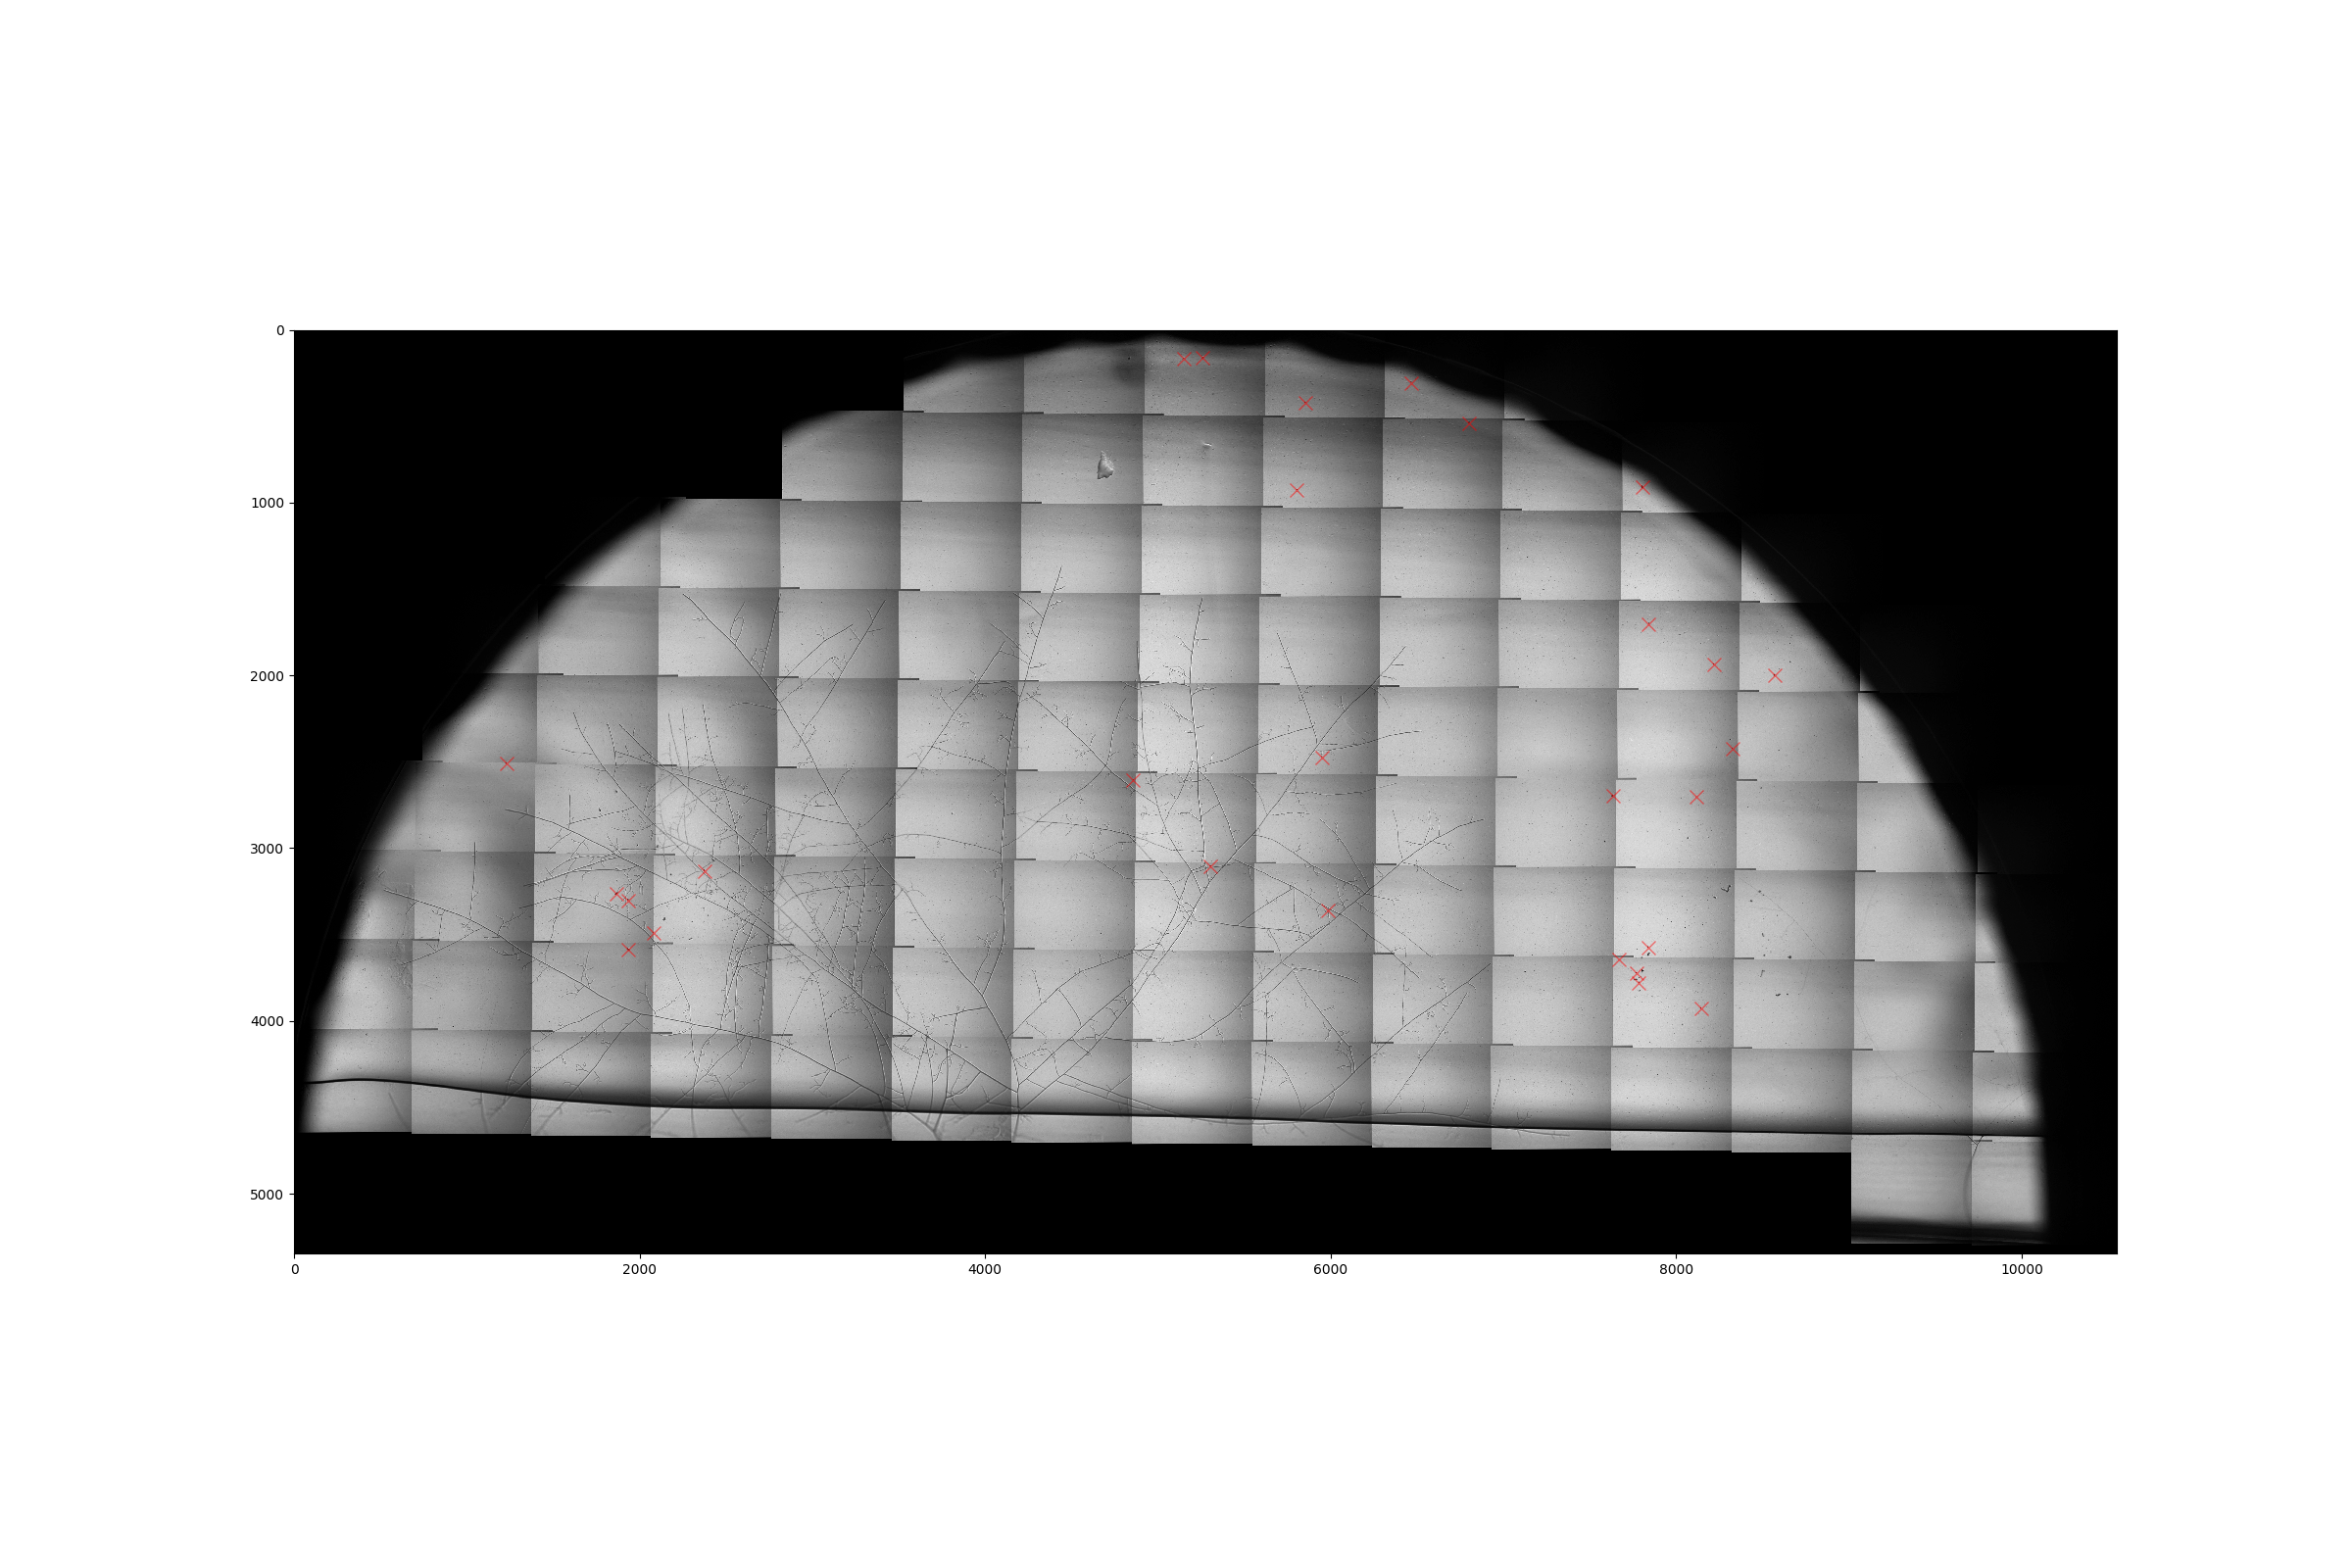

<AxesSubplot:>

In [17]:
import scipy.io as sio

select = exp.folders
table = select.sort_values(by="datetime", ascending=True)
path_spore_data = os.path.join(exp.directory, table["folder"].iloc[t])
spore_data = sio.loadmat(
    os.path.join(path_spore_data, "Analysis", "spores.mat")
)["spores"]
positions = [
            exp.timestep_to_general(np.flip(spore_data[i, :2]), t)
            for i in range(len(spore_data))
        ]
plot_full(
    exp,
    t,
    points=positions,
    downsizing=5,
    dilation=4,
    prettify=False,
    figsize=(24, 16),
    dpi=200,
)

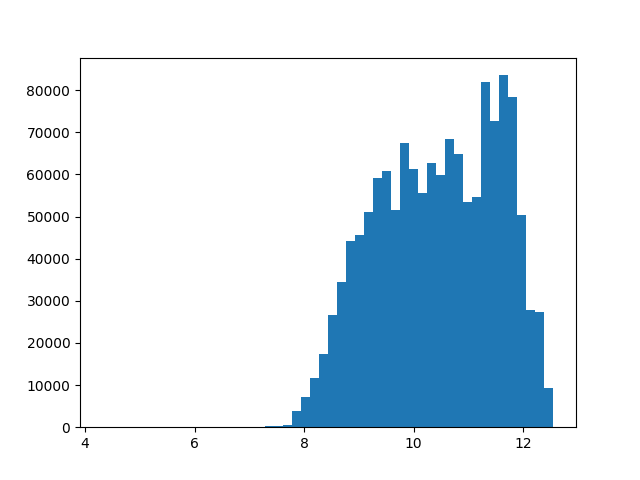

In [6]:
f = lambda edge: np.log(
    edge.width(t) * edge.length_um(t) * edge.end.degree(t) * edge.begin.degree(t)
)
edges = get_all_edges(exp, t)
values = [f(edge) for edge in edges]
weights = [edge.length_um(t) for edge in edges]

fig, ax = plt.subplots()
h = ax.hist(values, 50, weights=weights)

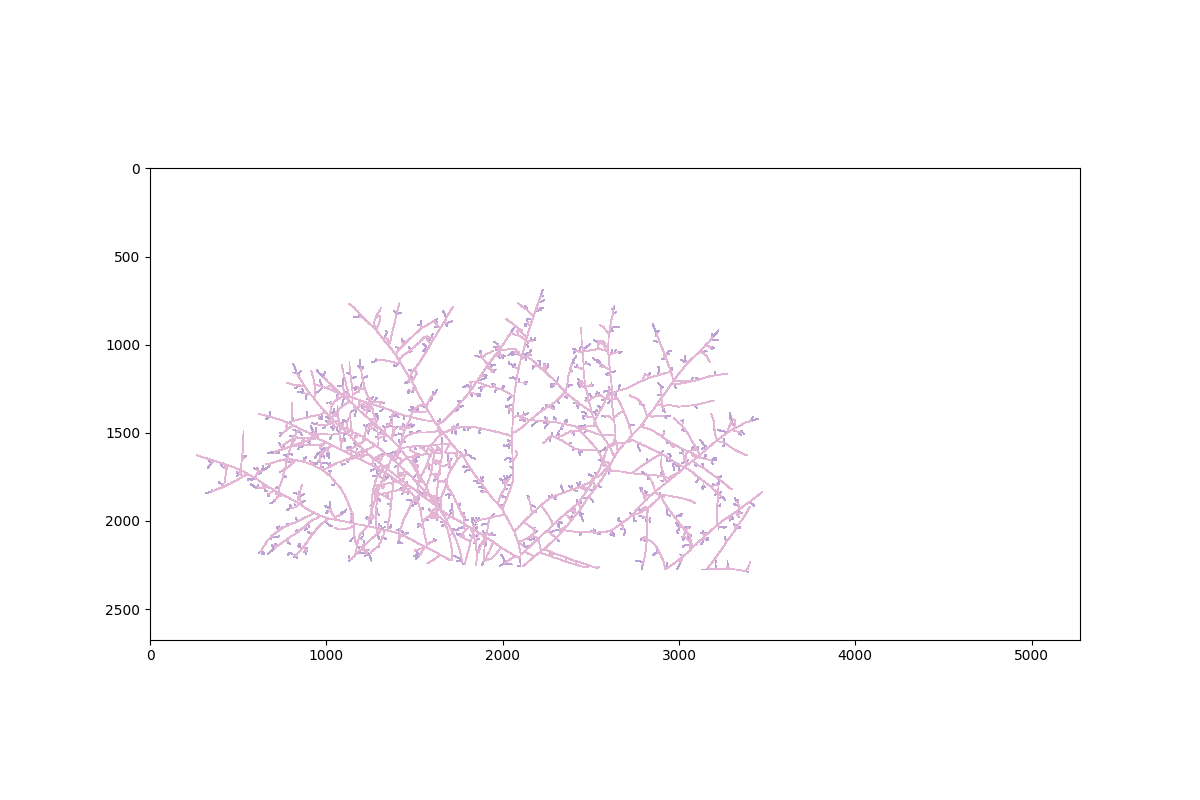

UnboundLocalError: local variable 'f' referenced before assignment

In [29]:
dpi = 400

vmax = 1
vmin = 0
downsizing = 10
fig,ax,f = plot_edge_color_value(
    exp,
    t,
    lambda edge: g(edge),
    cmap=cm.get_cmap("seismic", 100),
    v_min=vmin,
    v_max=vmax,
    show_background=False,
    dilation=10,
    figsize=(12, 8),
    downsizing = downsizing
)
x = [position[0]/downsizing for position in positions]
y = [position[1]/downsizing for position in positions]
ax.scatter(y,x)

In [8]:
def h(edge, t):
    boolean = (edge.end.degree(t) == 1 or edge.begin.degree(t) == 1) and edge.length_um(
        t
    ) < 1000
    # boolean +=((edge.width(t)*edge.length_um(t))<3000)*edge.width(t)<7
    return boolean


edges = get_all_edges(exp, t)
edge_tip = [edge for edge in edges if h(edge, t)]

In [6]:
from amftrack.pipeline.launching.run_super import run_parallel, run_launcher


folders = all_folders.loc[all_folders["unique_id"].isin(plates)]
folders = folders.loc[folders["/Analysis/skeleton_realigned_compressed.mat"] == True]
num_parallel = 32
time = "1:00:00"
skip = False
resolution = 10
args = [directory_targ, skip, resolution]
run_parallel(
    "extract_betweeness.py",
    args,
    folders,
    num_parallel,
    time,
    "betweenness",
    cpus=32,
    node="fat",
    name_job="bet",
)

sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 8 jobs.
sbatch: By default shared jobs get 7680 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 0.25 node, based on the number of CPUs, GPUs and the amount memory that you've requested.


Submitted batch job 3248531


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 8 jobs.
sbatch: By default shared jobs get 7680 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 0.25 node, based on the number of CPUs, GPUs and the amount memory that you've requested.


Submitted batch job 3248532


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 8 jobs.
sbatch: By default shared jobs get 7680 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 0.25 node, based on the number of CPUs, GPUs and the amount memory that you've requested.


Submitted batch job 3248533


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 8 jobs.
sbatch: By default shared jobs get 7680 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 0.25 node, based on the number of CPUs, GPUs and the amount memory that you've requested.


Submitted batch job 3248534


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 8 jobs.
sbatch: By default shared jobs get 7680 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 0.25 node, based on the number of CPUs, GPUs and the amount memory that you've requested.


Submitted batch job 3248535


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 8 jobs.
sbatch: By default shared jobs get 7680 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 0.25 node, based on the number of CPUs, GPUs and the amount memory that you've requested.


Submitted batch job 3248537


In [43]:
edges = get_all_edges(exp, t)
nodes = get_all_nodes(exp, t)
# nodes_source = [
#     node
#     for node in nodes
#     if not is_in_study_zone(node, t, 1000, 150)[1]
#     and is_in_study_zone(node, t, 1000, 150)[0]
# ]
nodes_source = nodes_source2
nodes_sink = [
    node
    for node in nodes
    if is_in_study_zone(node, t, 1000, 150)[1] and node.degree(t) == 1
]
weights = {(edge.begin.label, edge.end.label): edge.length_um(t) for edge in edges}
nx.set_edge_attributes(exp.nx_graph[t], weights, "length")
weights = {(edge.begin.label, edge.end.label): 1 / edge.length_um(t) for edge in edges}
nx.set_edge_attributes(exp.nx_graph[t], weights, "1/length")
t = 0
G = exp.nx_graph[t]
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
len_connected = [len(nx_graph.nodes) for nx_graph in S]
final_current_flow_betweeness = {}
final_betweeness = {}

for g in S:
    source = [node.label for node in nodes_source if node.label in g]
    sink = [node.label for node in nodes_sink if node.label in g]
    # current_flow_betweeness = nx.edge_current_flow_betweenness_centrality_subset(
    #     g, source, sink, weight="1/length"
    # )
    # betweeness = nx.edge_current_flow_betweenness_centrality_subset(
    #     g, sink, source, weight="length"
    # )

    betweeness = nx.edge_betweenness_centrality_subset(g,source,sink,normalized=True,weight = "length")
    # for edge in current_flow_betweeness.keys():
    #     final_current_flow_betweeness[edge] = current_flow_betweeness[edge]
    for edge in betweeness.keys():
        final_betweeness[edge] = betweeness[edge]

for edge in exp.nx_graph[t].edges:
    # if (
    #     edge not in final_current_flow_betweeness.keys()
    #     and (edge[1], edge[0]) not in final_current_flow_betweeness.keys()
    # ):
    #     final_current_flow_betweeness[edge] = 0
    if (
        edge not in final_betweeness.keys()
        and (edge[1], edge[0]) not in final_betweeness.keys()
    ):
        final_betweeness[edge] = 0
nx.set_edge_attributes(exp.nx_graph[t], final_betweeness, "betweenness")


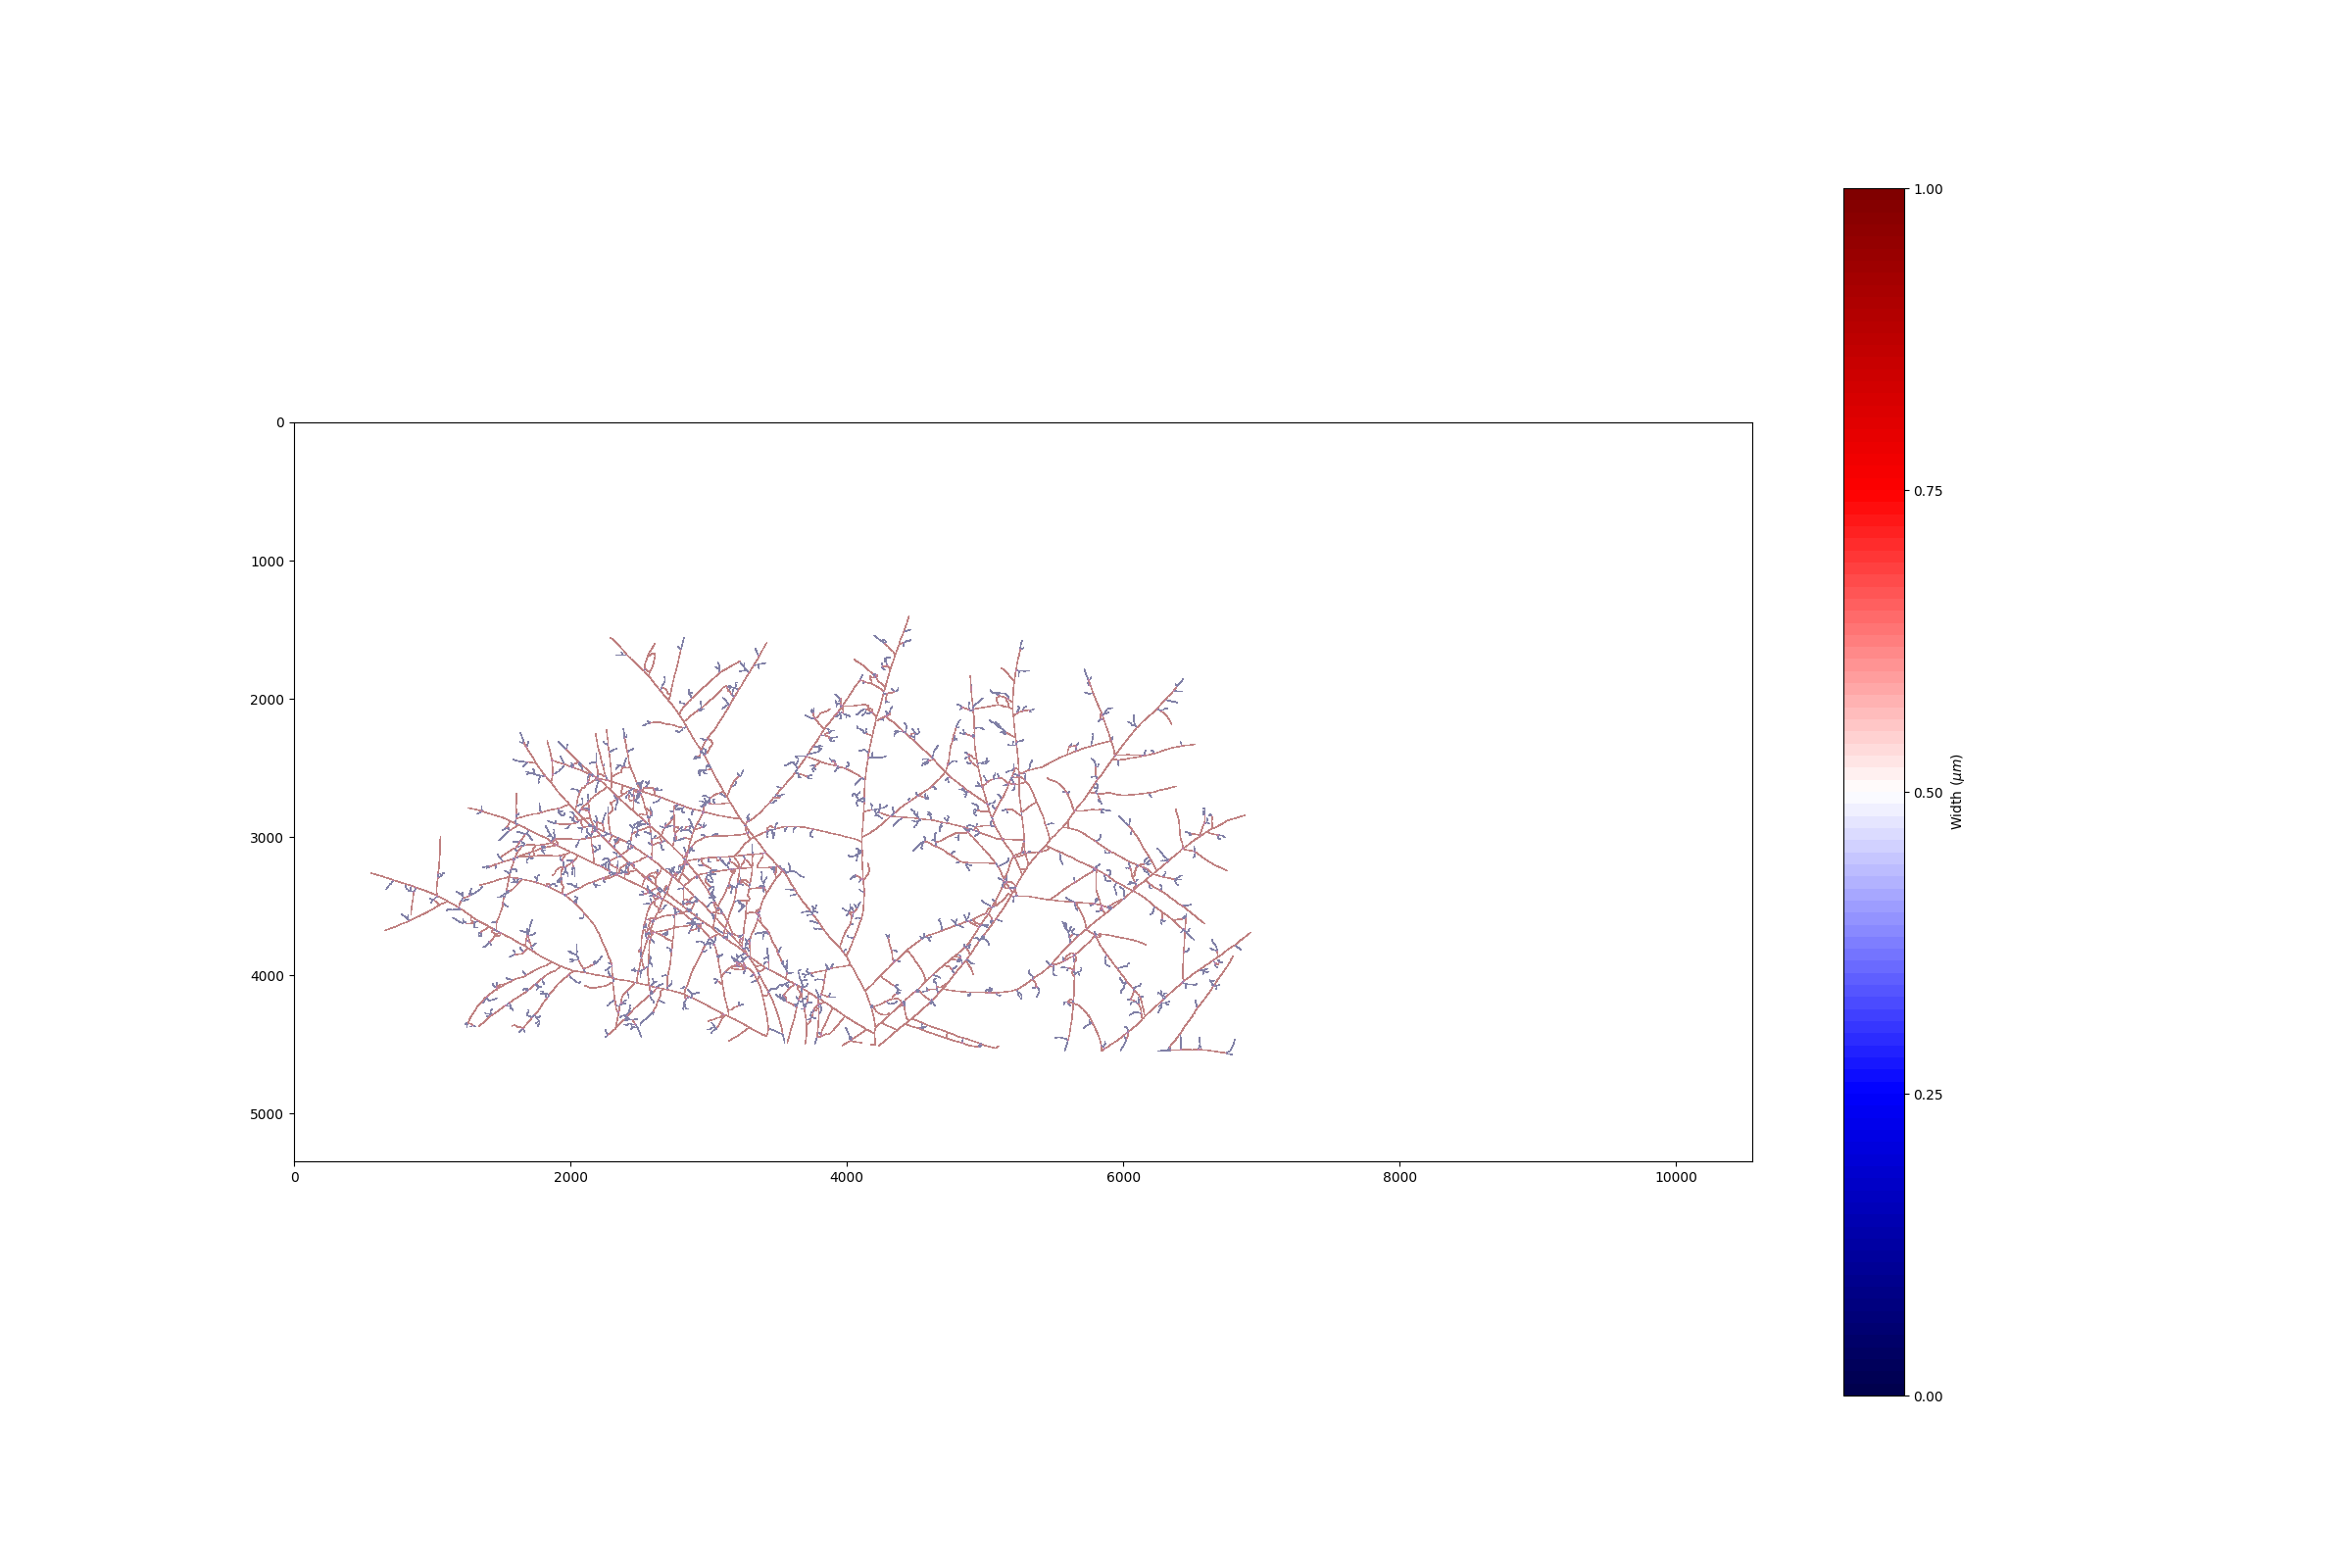

In [8]:
dpi = 400

vmax = 1
vmin = 0
plot_edge_color_value(
    exp,
    t,
    lambda edge: f(edge) > 10,
    cmap=cm.get_cmap("seismic", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(24, 16),
)
path = r"/scratch-shared/amftrack/transport/full_picture/"
file_name = f"BAS.png"
save_path = os.path.join(path, file_name)
plt.savefig(save_path, dpi=dpi)

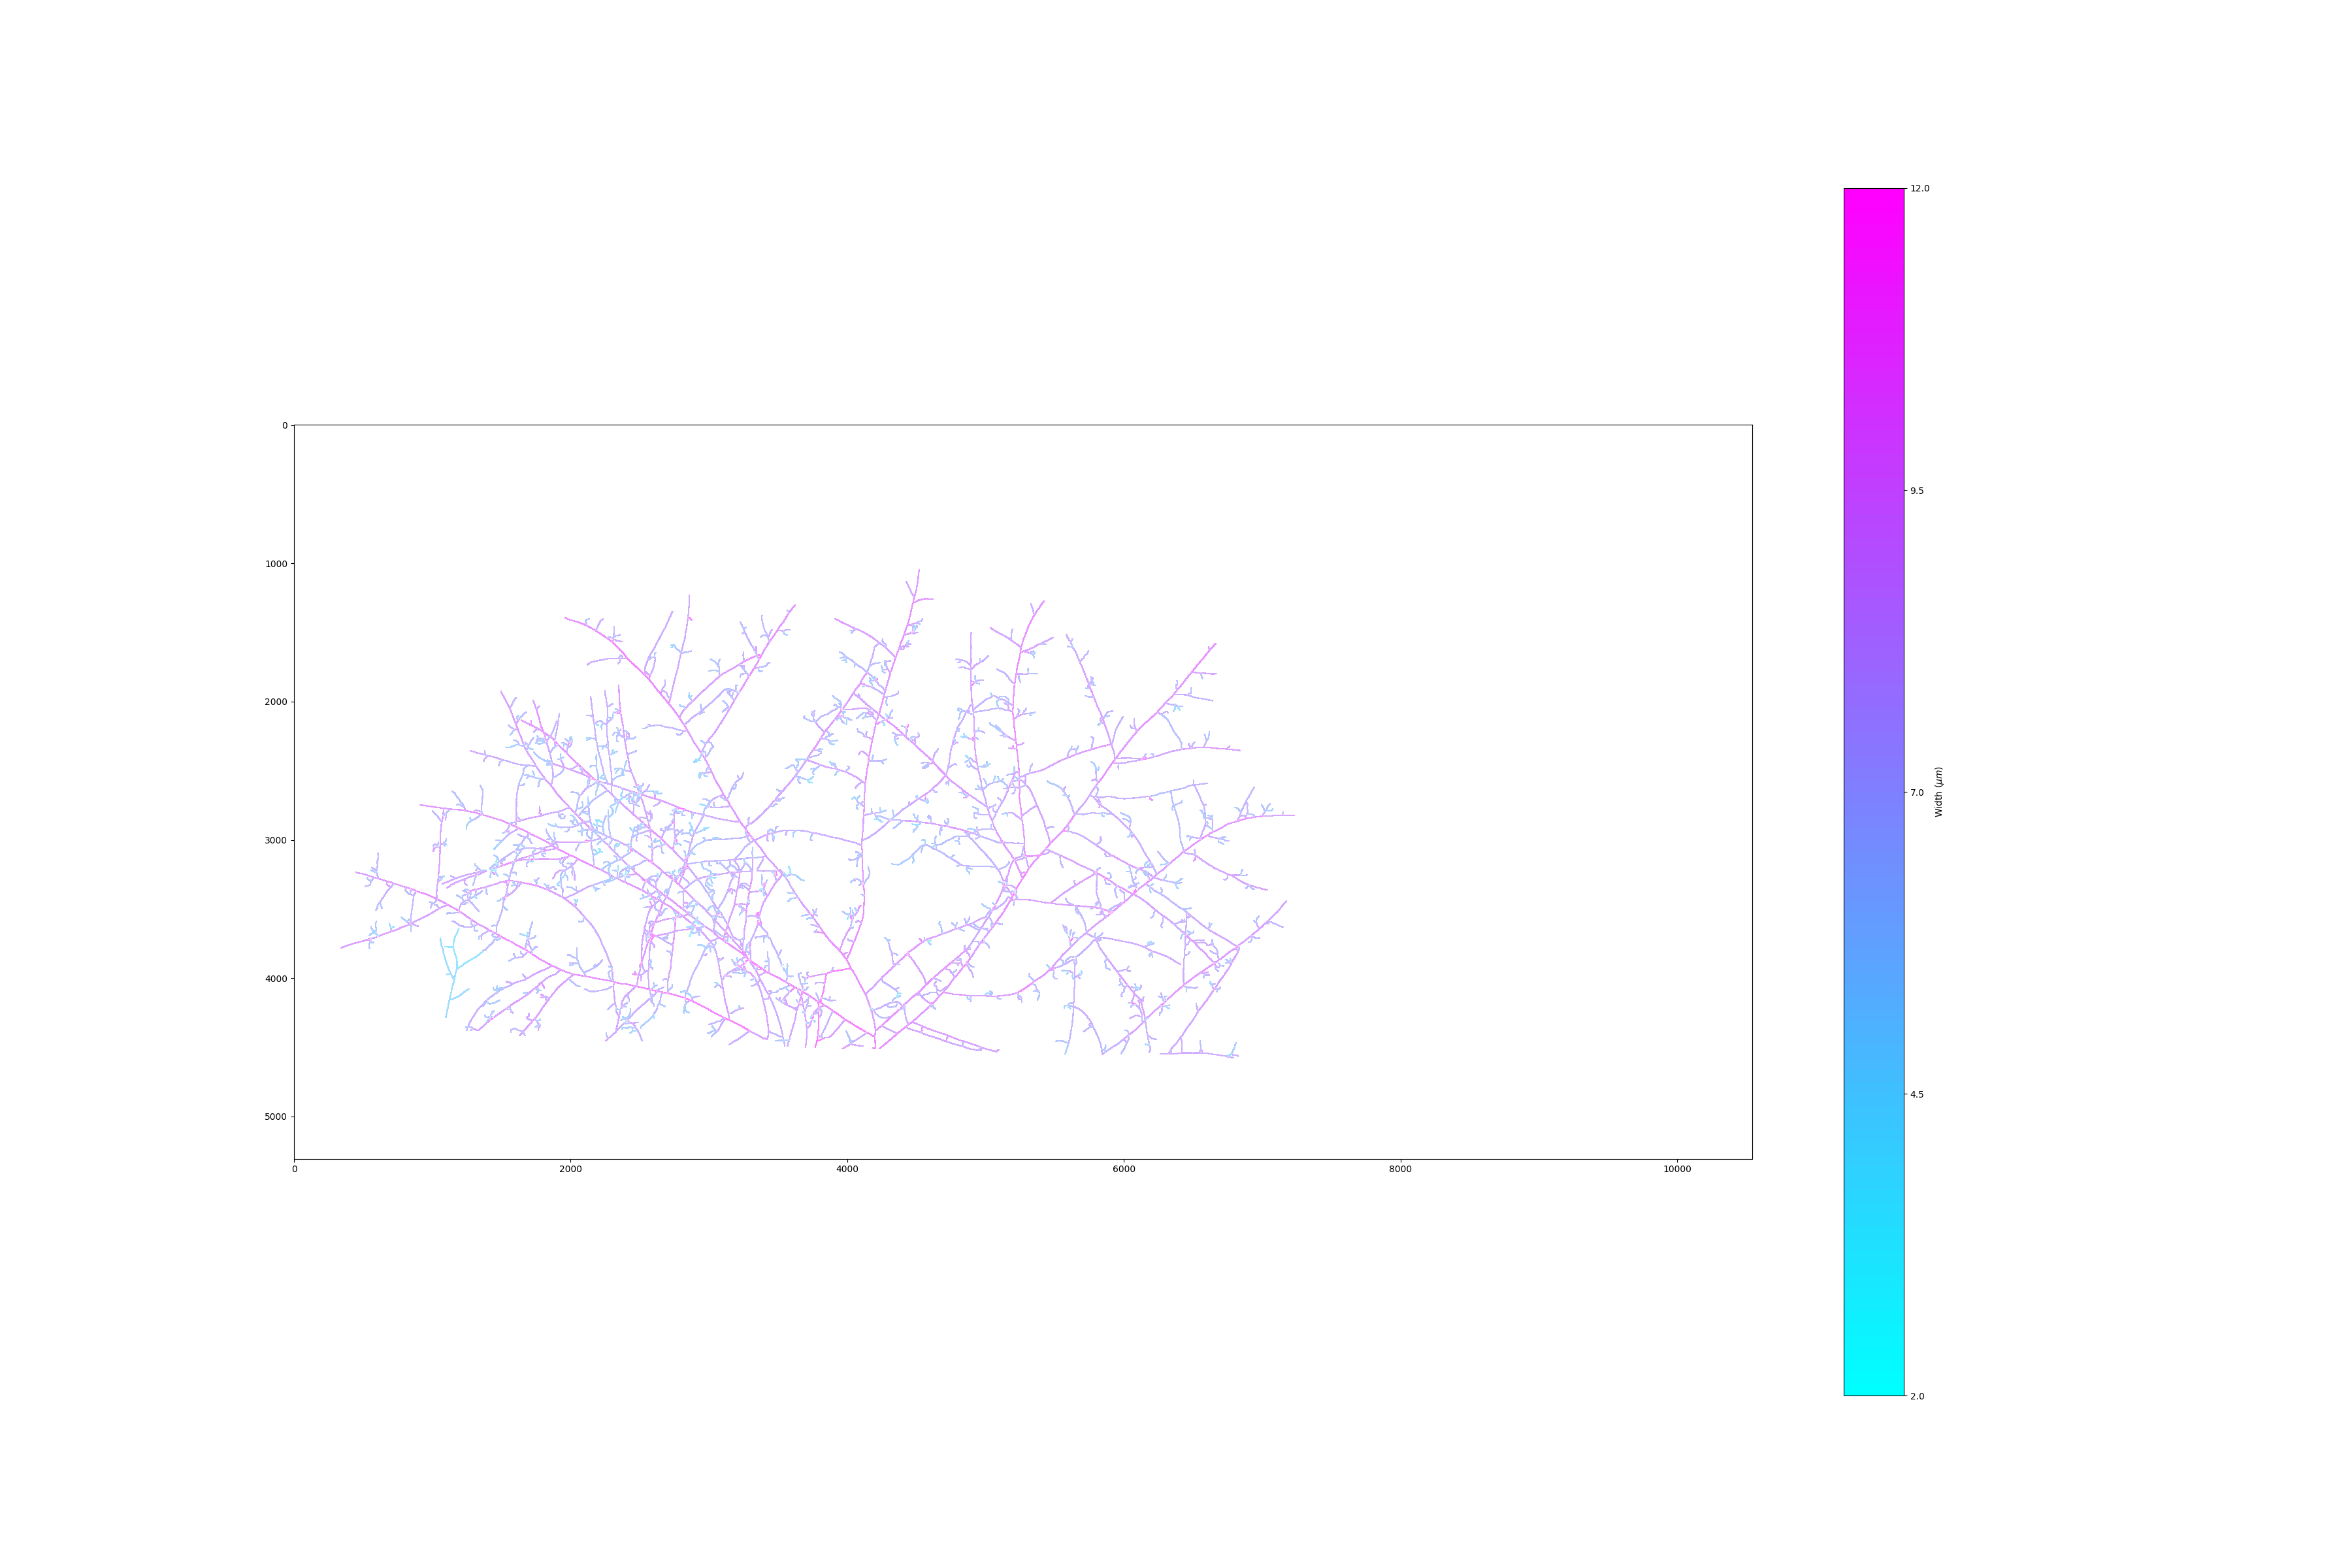

NameError: name 'dpi' is not defined

In [6]:
vmax = 12
vmin = 2
plot_edge_color_value(
    exp,
    t,
    lambda edge: edge.width(t),
    cmap=cm.get_cmap("cool", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
)
path = r"/scratch-shared/amftrack/transport/full_picture/"
file_name = f"width.png"
save_path = os.path.join(path, file_name)
plt.savefig(save_path, dpi=dpi)

KeyError: 'betweenness'

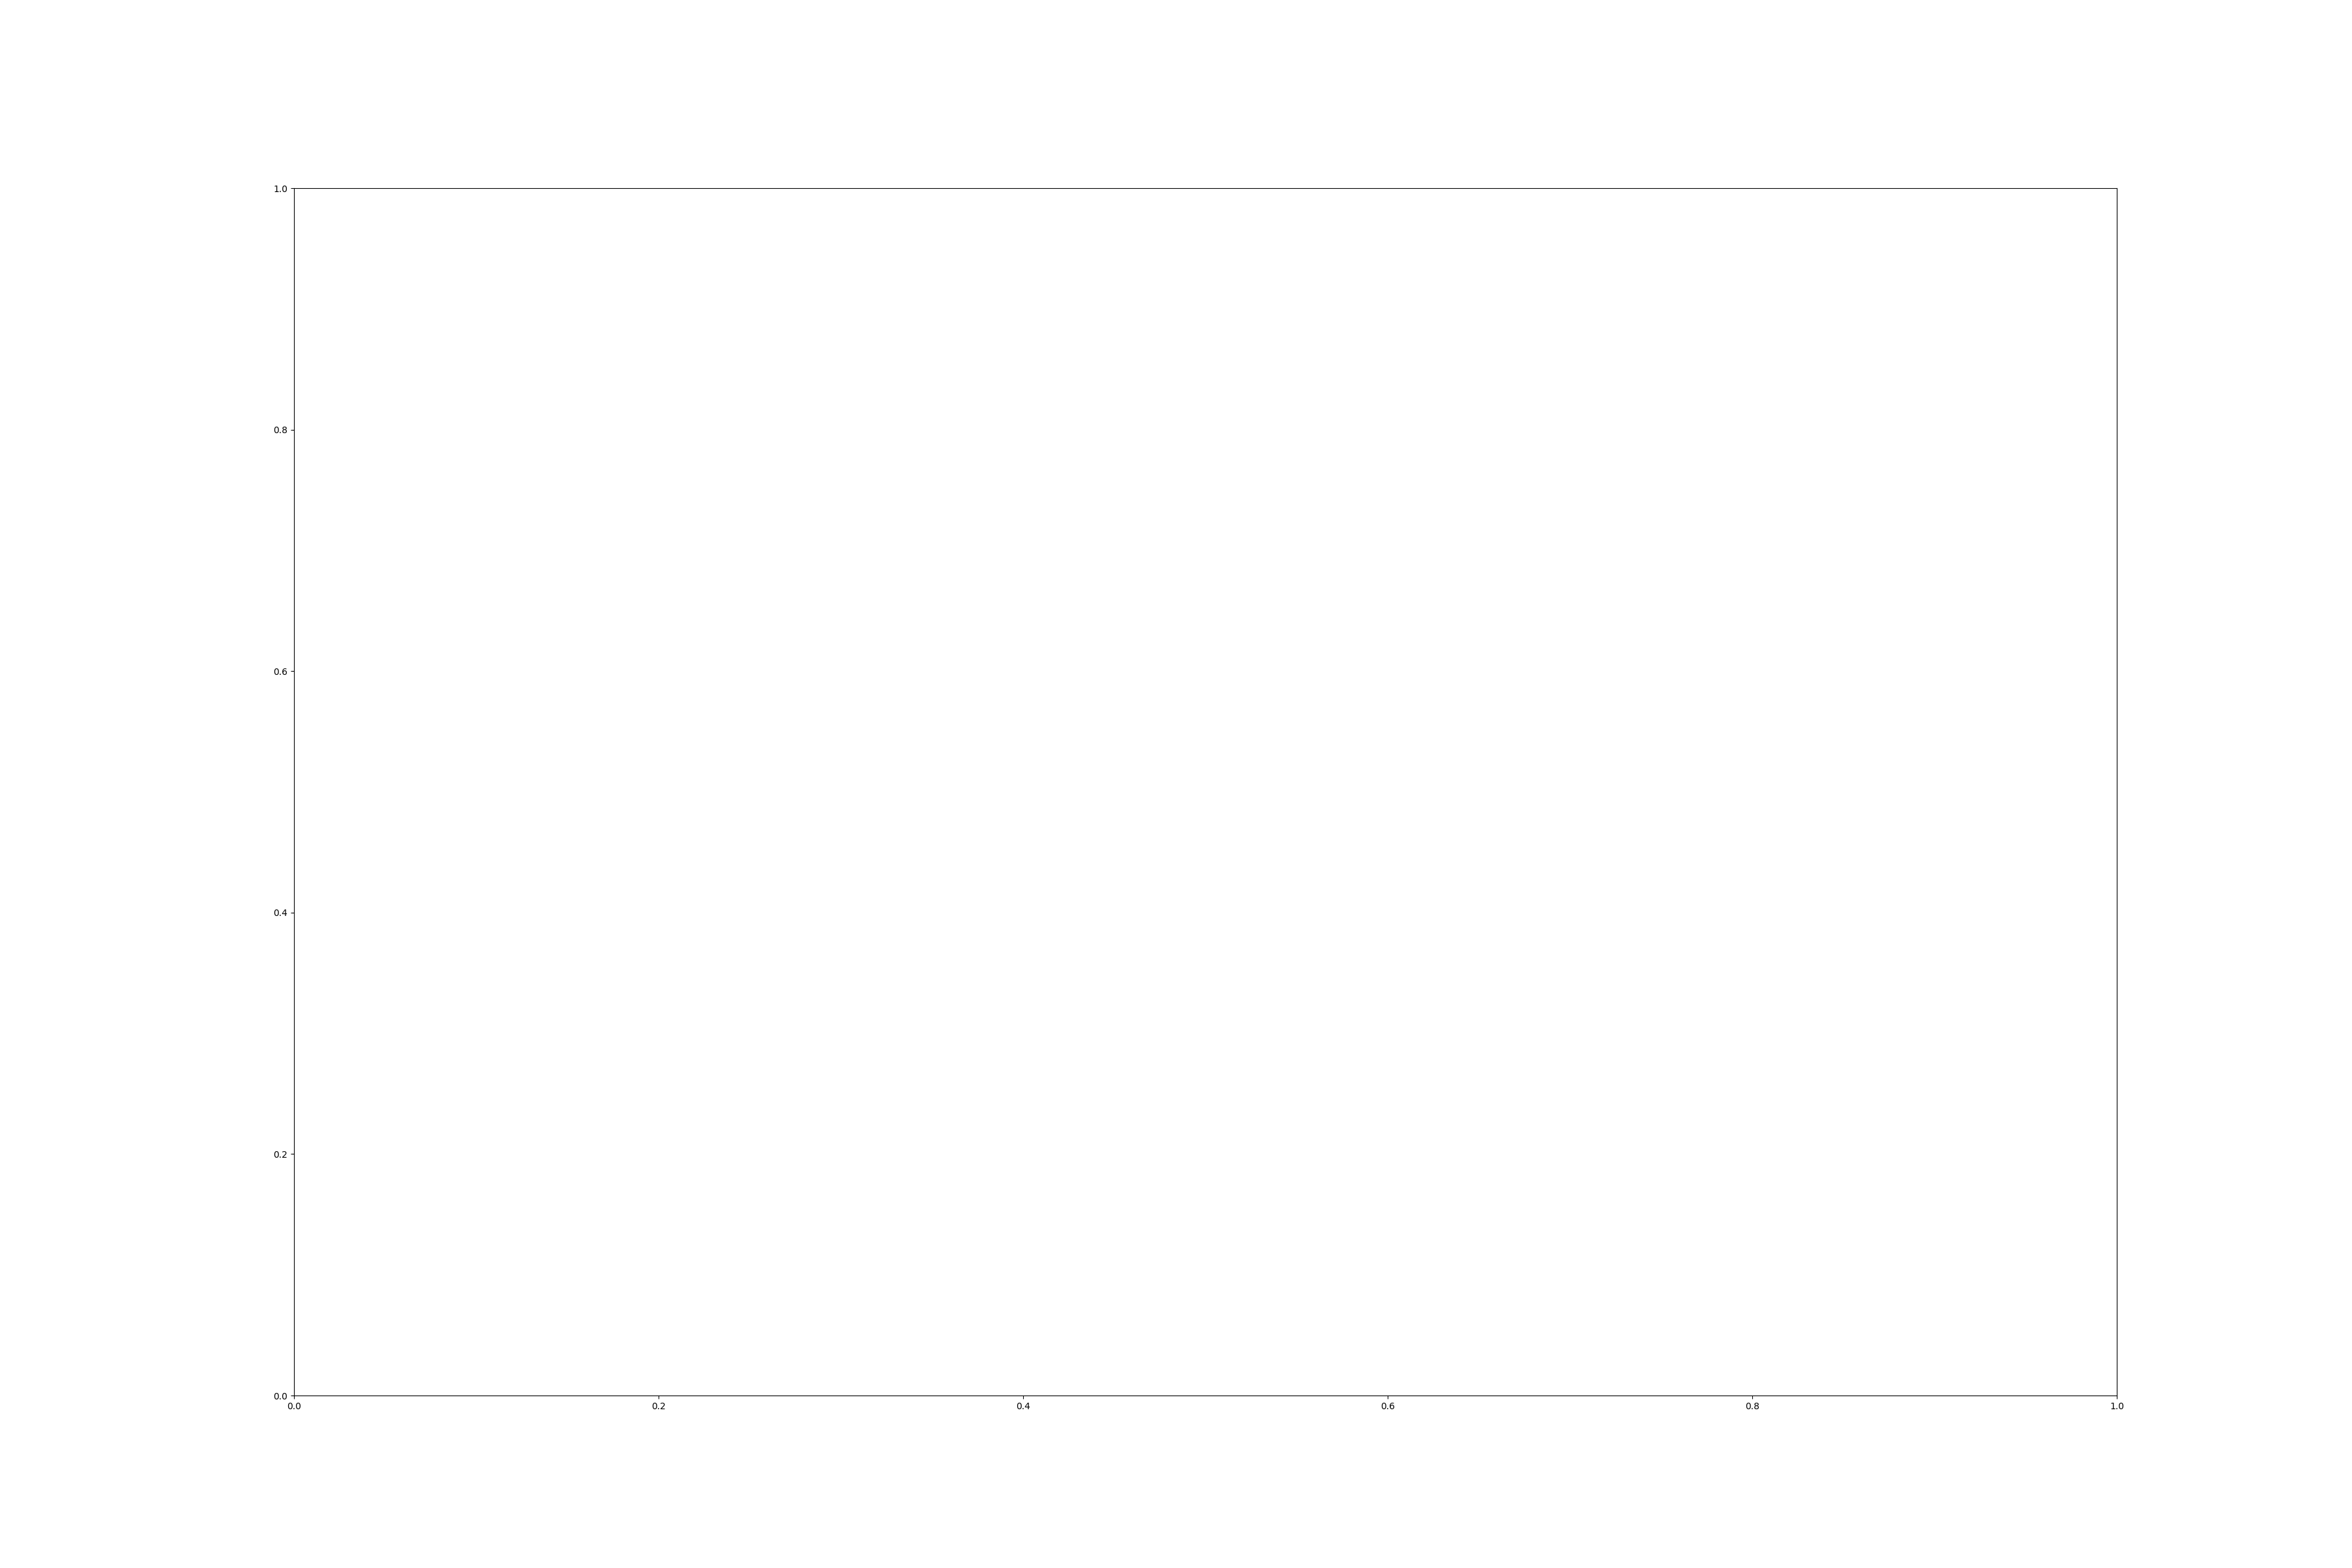

In [9]:
plt.close("all")
vmax = -2.2
vmin = -4.5
ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.betweeness(t)),
    cmap=cm.get_cmap("autumn", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
)
path = r"/scratch-shared/amftrack/transport/full_picture/"
file_name = f"betweeness.png"
save_path = os.path.join(path, file_name)
plt.savefig(save_path, dpi=dpi)

In [ ]:
plt.close("all")
vmax = -2.2
vmin = -4.5
ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.current_flow_betweeness(t)),
    cmap=cm.get_cmap("cool", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
)
path = r"/scratch-shared/amftrack/transport/full_picture/"
file_name = f"betweeness_random.png"
save_path = os.path.join(path, file_name)
plt.savefig(save_path, dpi=dpi)
file_name = f"betweeness_random.csv"
save_path = os.path.join(path, file_name)
plt.savefig(save_path)
file_name = f"betweeness_random.eps"
save_path = os.path.join(path, file_name)
plt.savefig(save_path)

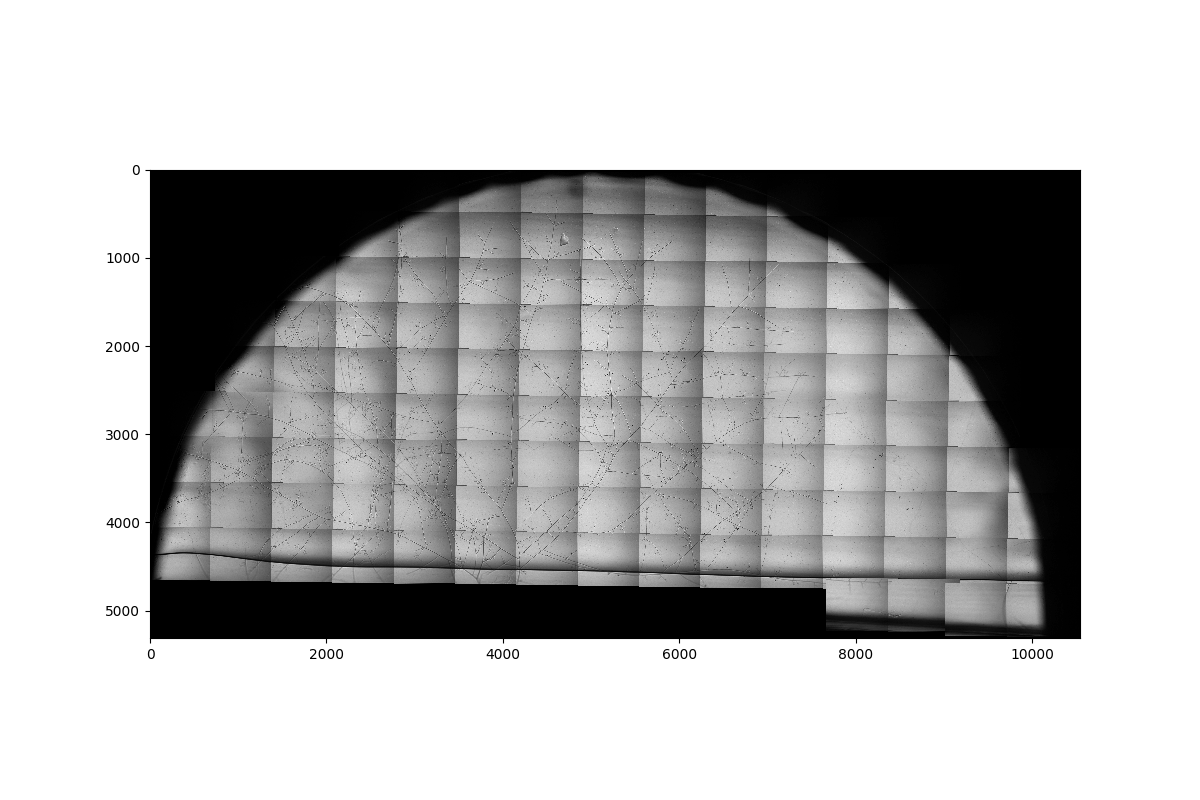

In [6]:
vmax = 0
vmin = 10
dpi = 400

# ax = plot_edge_color_value(exp,t,lambda edge : 5,cmap = cm.get_cmap("Reds", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=True,dilation =10,figsize = (12,8))
ax = plot_full(exp, t)
ax.scatter(
    spore_datatable["y"] / 5, spore_datatable["x"] / 5, s=20, color="blue", alpha=0.4
)
path = r"/scratch-shared/amftrack/transport/full_picture/"
file_name = f"spores.png"
save_path = os.path.join(path, file_name)
# plt.savefig(save_path, dpi=dpi)

In [7]:
edges = get_all_edges(exp, t)
nodes = get_all_nodes(exp, t)

In [8]:
nodes_source = [
    node
    for node in nodes
    if not is_in_study_zone(node, t, 1000, 150)[1]
    and is_in_study_zone(node, t, 1000, 150)[0]
]

In [9]:
nodes_sink = [
    node
    for node in nodes
    if is_in_study_zone(node, t, 1000, 150)[1] and node.degree(t) == 1
]
# nodes_sink = [node for node in nodes if is_in_study_zone(node,t,1000,150)[1] ]

In [16]:
len(nodes_source), len(nodes_sink)

(138, 852)

In [10]:
weights = {(edge.begin.label, edge.end.label): edge.length_um(t) for edge in edges}
nx.set_edge_attributes(exp.nx_graph[t], weights, "length")
weights = {(edge.begin.label, edge.end.label): 1 / edge.length_um(t) for edge in edges}
nx.set_edge_attributes(exp.nx_graph[t], weights, "1/length")

In [32]:
t = 0
G = exp.nx_graph[t]
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
len_connected = [len(nx_graph.nodes) for nx_graph in S]
final_current_flow_betweeness = {}
final_betweeness = {}

for g in S:
    source = [node.label for node in nodes_source if node.label in g]
    sink = [node.label for node in nodes_sink if node.label in g]
    current_flow_betweeness = nx.edge_current_flow_betweenness_centrality_subset(
        g, source, sink, weight="1/length"
    )
    betweeness = nx.edge_current_flow_betweenness_centrality_subset(
        g, sink, source, weight="length"
    )

    # betweeness = nx.edge_betweenness_centrality_subset(g,source,sink,normalized=True,weight = "length")
    for edge in current_flow_betweeness.keys():
        final_current_flow_betweeness[edge] = current_flow_betweeness[edge]
    for edge in betweeness.keys():
        final_betweeness[edge] = betweeness[edge]

for edge in exp.nx_graph[t].edges:
    if (
        edge not in final_current_flow_betweeness.keys()
        and (edge[1], edge[0]) not in final_current_flow_betweeness.keys()
    ):
        final_current_flow_betweeness[edge] = 0
    if (
        edge not in final_betweeness.keys()
        and (edge[1], edge[0]) not in final_betweeness.keys()
    ):
        final_betweeness[edge] = 0
nx.set_edge_attributes(
    exp.nx_graph[t], final_current_flow_betweeness, "current_flow_betweenness"
)
nx.set_edge_attributes(exp.nx_graph[t], final_betweeness, "betweenness")
betweenessses = list(final_current_flow_betweeness.values())
np.mean(betweenessses), np.max(betweenessses)

(0.0002276309625805852, 0.0019489357368749837)

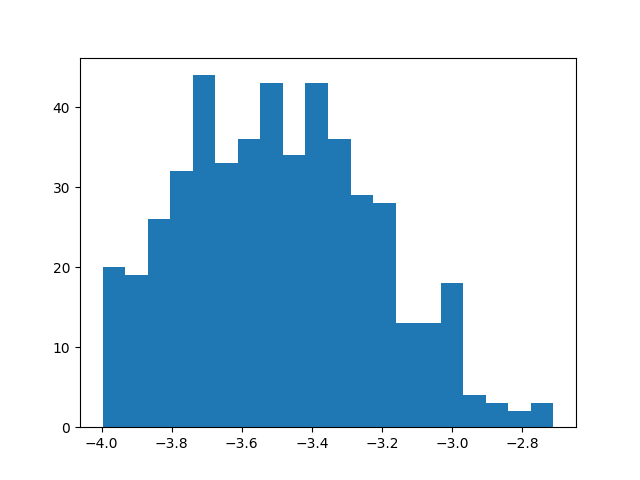

In [30]:
betweenessses = list(final_current_flow_betweeness.values())
betweenessses2 = list(final_betweeness.values())
fig, ax = plt.subplots()
h = ax.hist(np.log10([bet for bet in betweenessses if bet > 1e-4]), 20)

In [16]:
final_current_flow_betweeness[(527418, 512522)], final_betweeness[(527418, 512522)]

(0.0004879946616729095, 0.00048799466167290923)

In [12]:
final_current_flow_betweeness[(527418, 512522)], final_betweeness[(527418, 512522)]

(0.0004879946616729095, 0.000504582530241318)

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


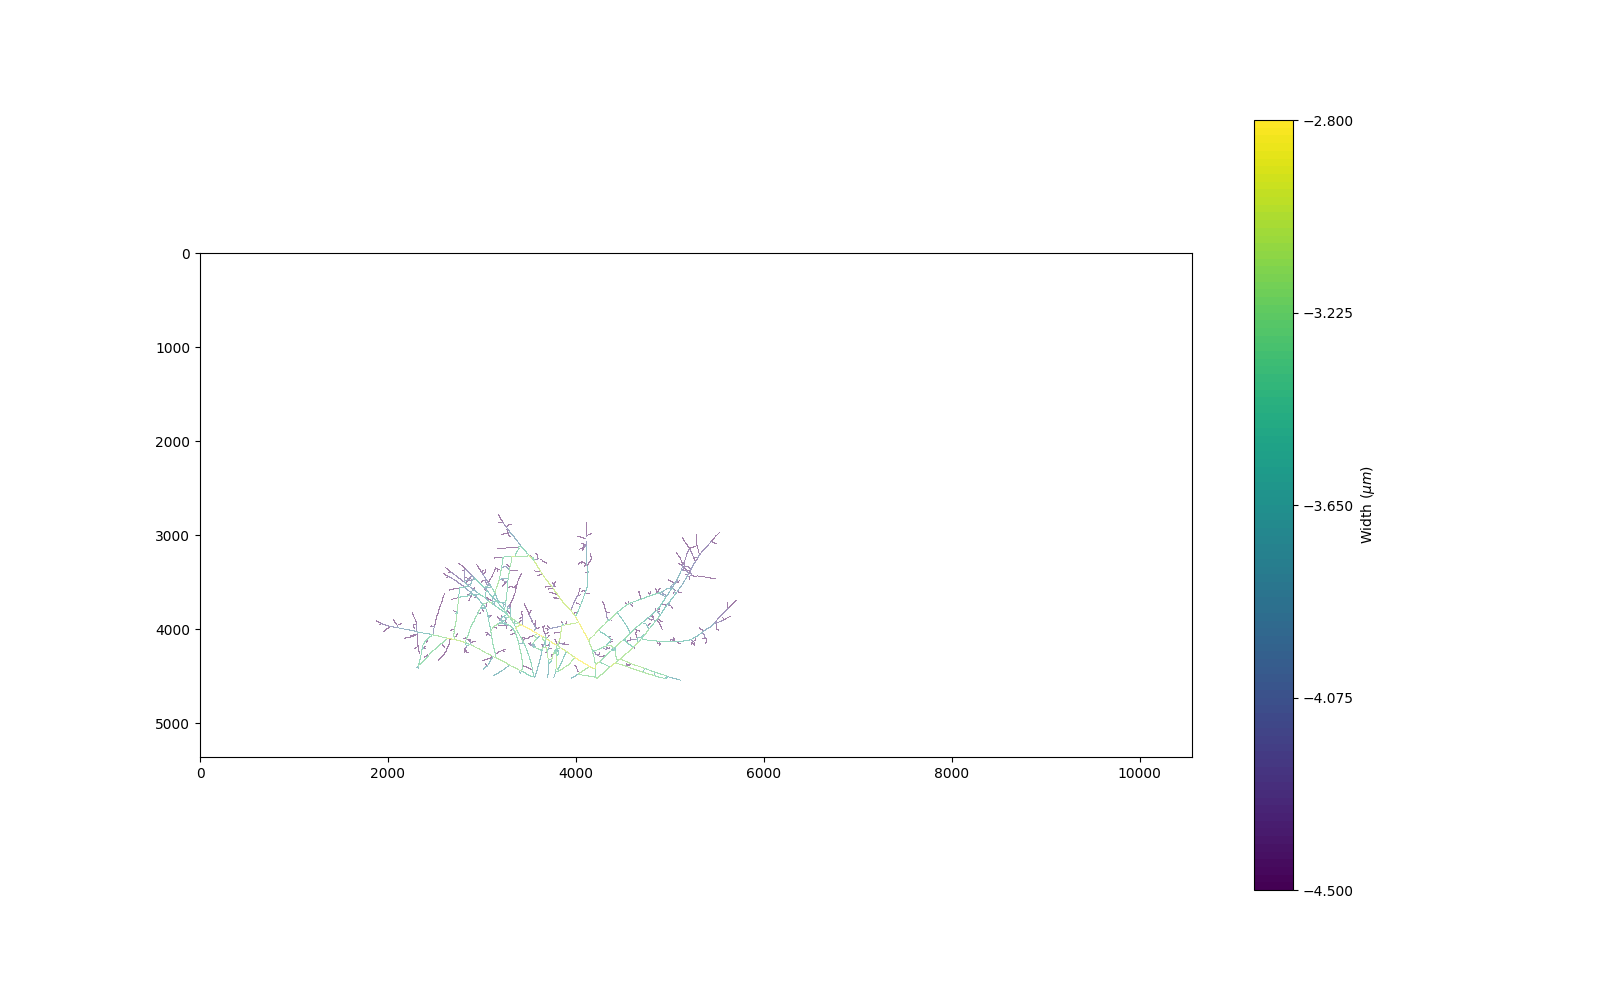

In [33]:
plt.close("all")
vmax = -2.8
vmin = -4.5
ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.current_flow_betweeness(t)),
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(16, 10),
)
# path = r"/scratch-shared/amftrack/transport/full_picture/"
# file_name = f'betweeness_random.png'
# save_path = os.path.join(path,file_name)
# plt.savefig(save_path, dpi=dpi)

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


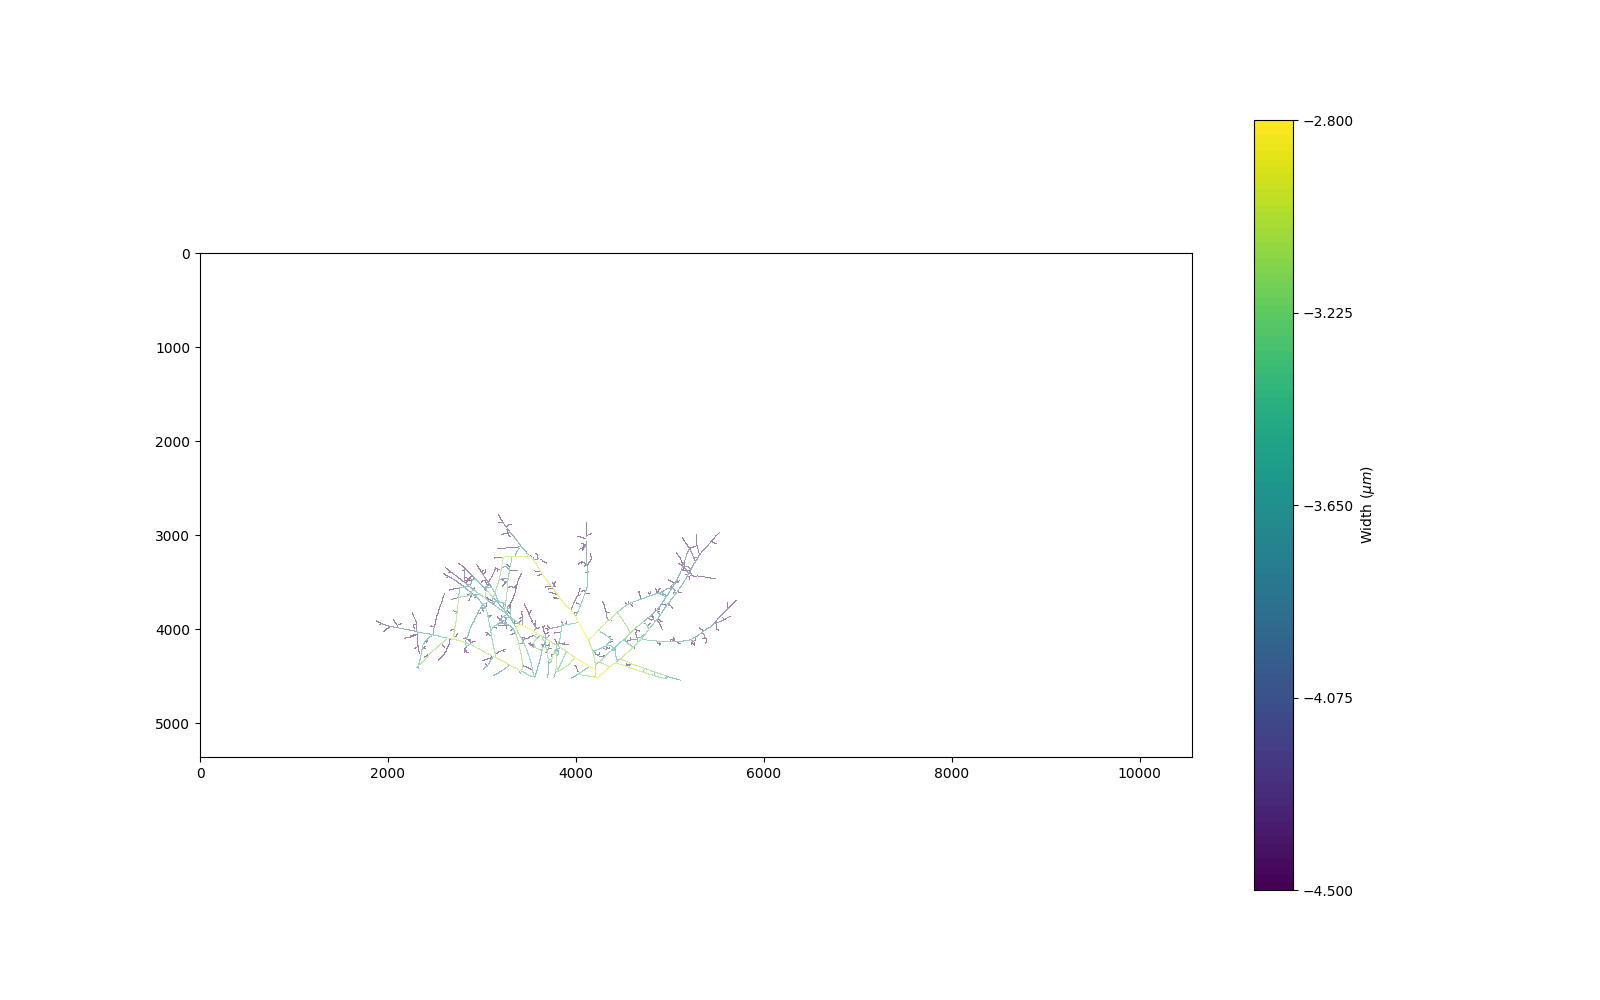

In [35]:
vmax = -2.8
vmin = -4.5
ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.betweeness(t)),
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(16, 10),
)
# path = r"/scratch-shared/amftrack/transport/full_picture/"
# file_name = f'betweeness_random.png'
# save_path = os.path.join(path,file_name)
# plt.savefig(save_path, dpi=dpi)

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


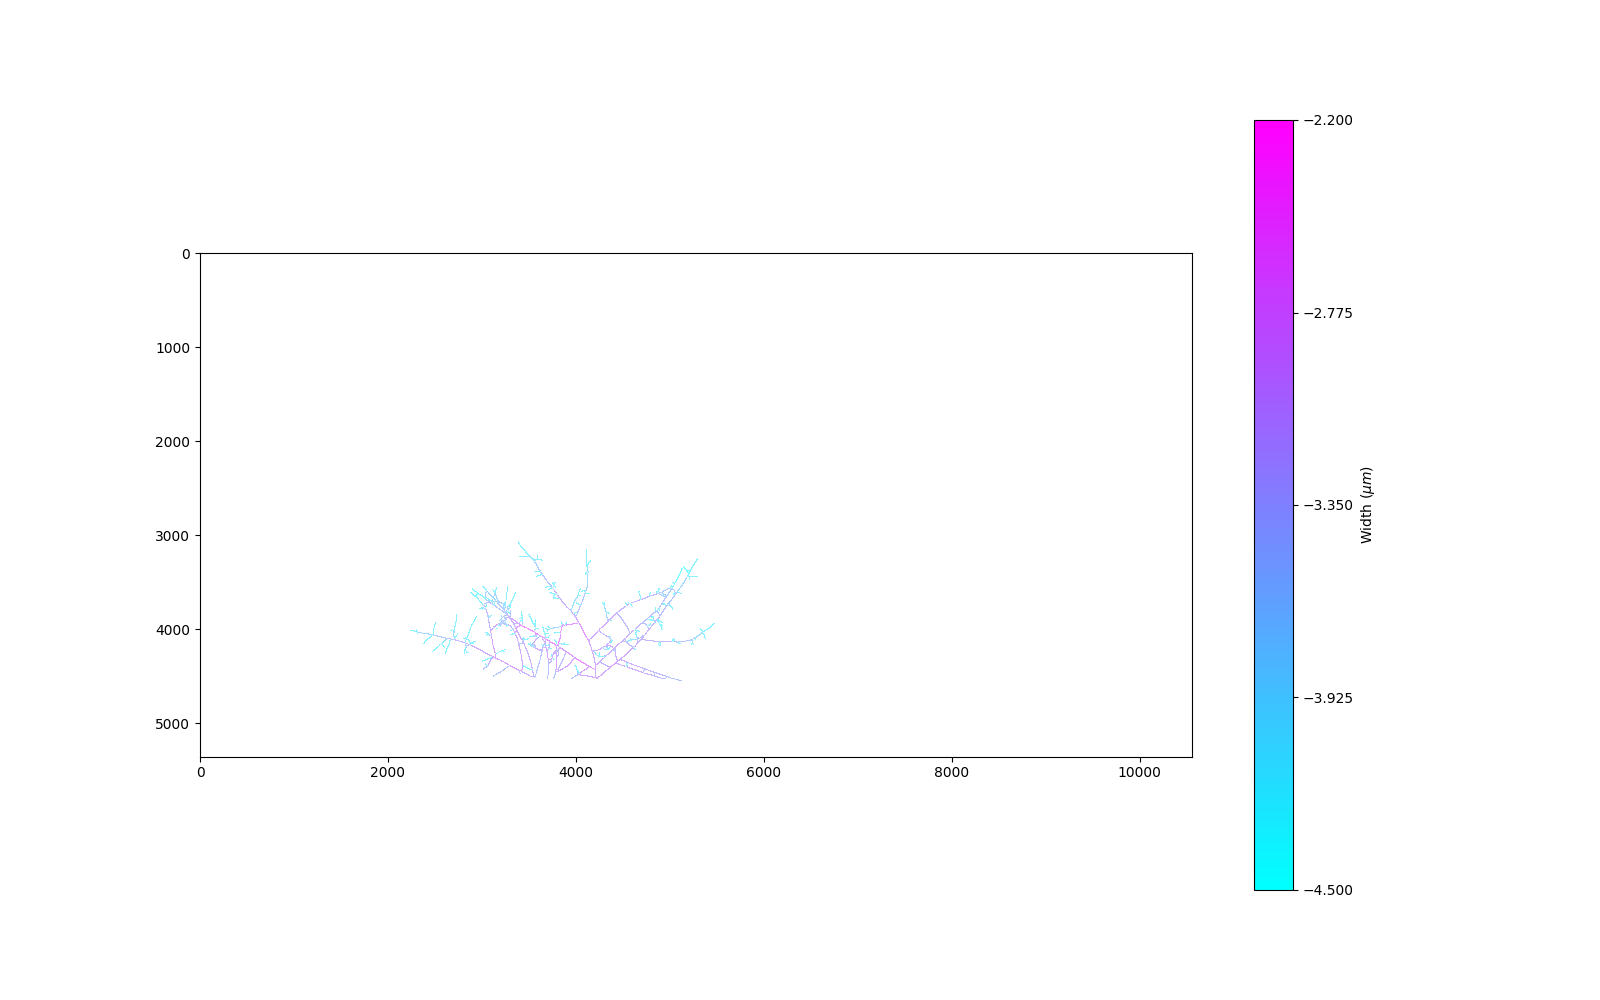

In [24]:
plt.close("all")
vmax = -2.8
vmin = -4.5
ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.current_flow_betweeness(t)),
    cmap=cm.get_cmap("cool", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(16, 10),
)
# path = r"/scratch-shared/amftrack/transport/full_picture/"
# file_name = f'betweeness_random.png'
# save_path = os.path.join(path,file_name)
# plt.savefig(save_path, dpi=dpi)

In [ ]:
betweenessses = list(current_flow_betweeness.values())
vmax = np.log10(np.max(betweenessses))
vmax

In [ ]:
betweenessses = [edge.current_flow_betweeness(t) for edge in edges]
betweenessses = [betweeness for betweeness in betweenessses if betweeness > 1e-5]
np.max(betweenessses), np.mean(betweenessses)
fig, ax = plt.subplots()
ax.hist(np.log10(betweenessses))

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


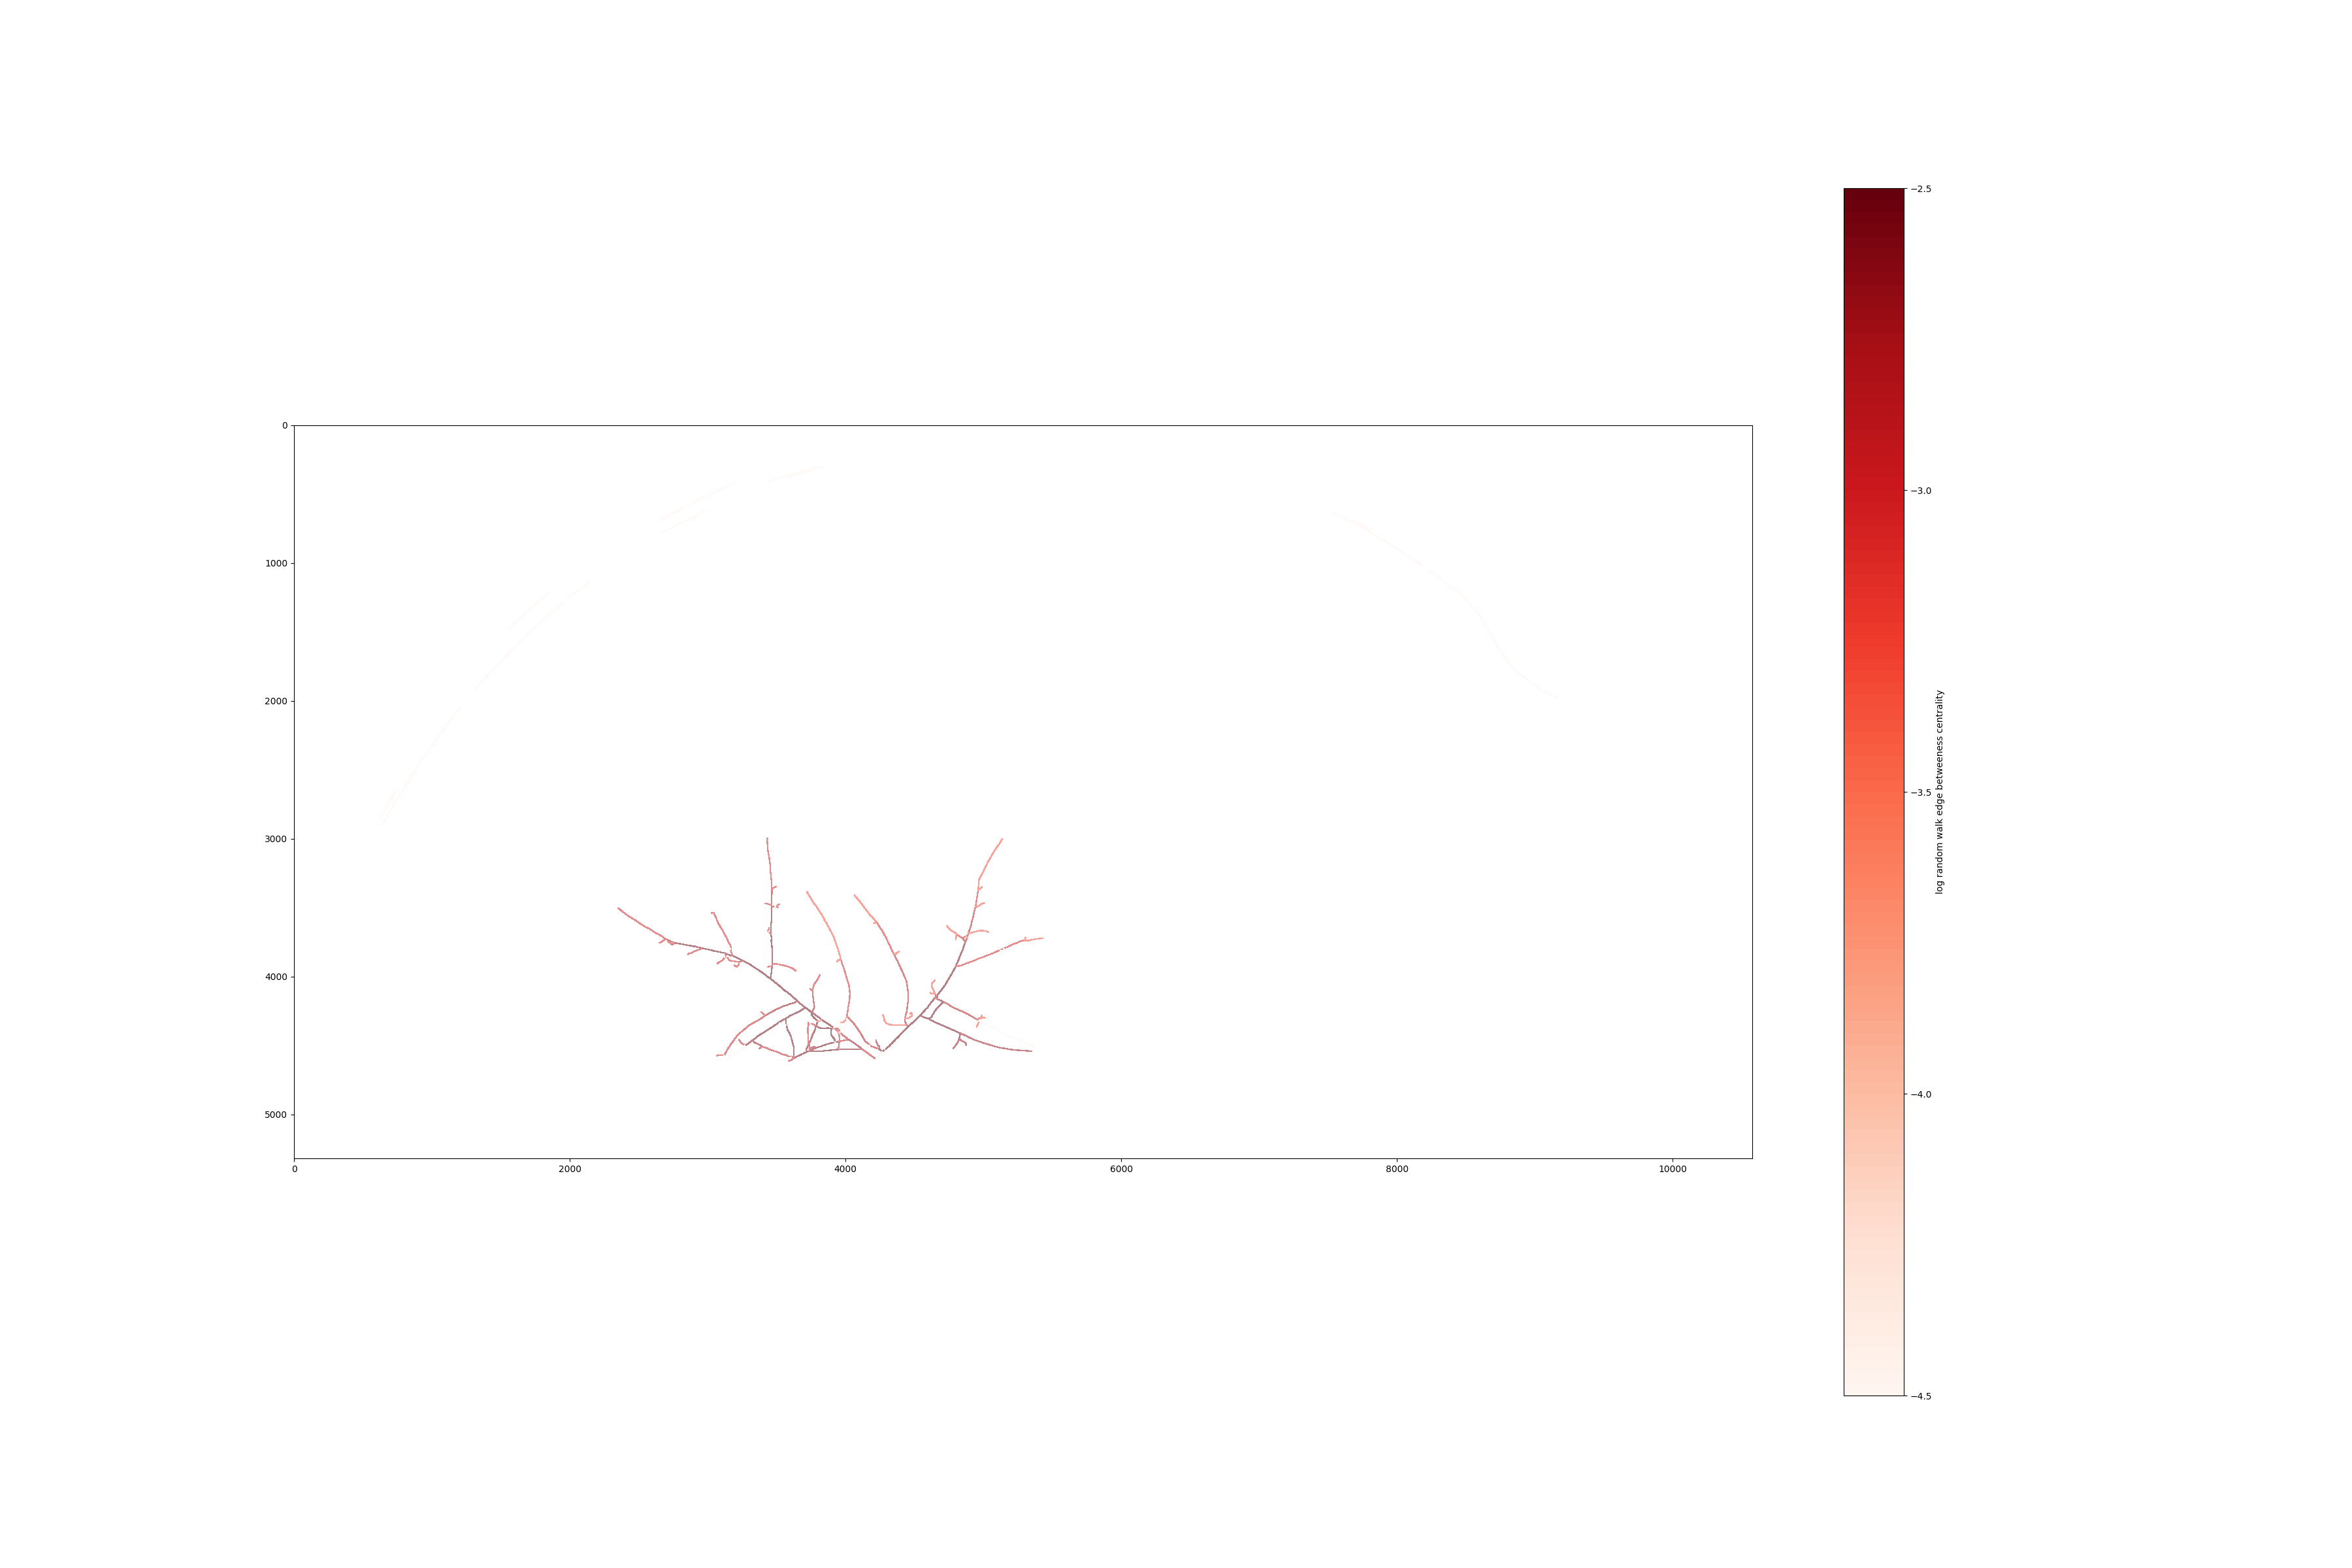

<AxesSubplot:>

In [ ]:
plt.close("all")
# betweenessses = list(current_flow_betweeness.values())
vmax = -2.5
vmin = -4.5

plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.current_flow_betweeness(t)),
    cmap=cm.get_cmap("Reds", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    label_colorbar="log random walk edge betweeness centrality",
)

In [ ]:
betweenessses = [edge.betweeness(t) for edge in edges]
betweenessses = [betweeness for betweeness in betweenessses if betweeness > 0]
np.max(betweenessses), np.mean(betweenessses)
fig, ax = plt.subplots()
ax.hist(np.log10(betweenessses))